# **Statistical Rethinking: A Bayesian course with examples in Python**
# **Ch 4 - Geocentric Models (Part 1)**

Egyptian astronomer and mathematician, Cladius Ptolemy (90-168 C.E), was famous for building his geocentric model of the solar system that, while scientifically incorrect due to the solar system actually being *heliocentric*, was genius for his era for building an incredibally accurate mathematical model on the motion of the planets (all without a computer!). To do so, he employed a device called a **epicycle**, which was a circle in a circle, and was utilized for thousands of years to predict planetary motion. In addition, Ptolemy's model was an excellent example of a generalized system of approximation.

To some degree, **linear regression** models are like the geocentric models of applied statistics in the sense that its used to *describe* a large variety of natural phenomena. However, if we read into it too literally, we're likely to make mistakes. To clarify, by "linear regression," we're referring to a family of simple statistical golems that attempt to learn about the mean and variance of some measurement using an additive combination of other measurements. Under a Bayesian/probability interpretation, linear regression *assumes* a Gaussian distribution to describe our model's uncertainty about some measurement of interest and is universally useful for building a foundation for regression models.

<img src="https://cdn.britannica.com/36/137736-050-C05FC854/diagram-Ptolemaic-Harmonia-Macrocosmica-Andreas-Cellarius-system-1660.jpg" width=700 height=500>

In [89]:
import re
import math
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from patsy import dmatrix

from scipy.interpolate import griddata

In [90]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

## *Section 4.1* - Why normal distributions are normal

Let's use the following *thought experiment* to simulate a Gaussian/normal distribution. Suppose we had a few thousand football players, each with a coin on hand, lined up on the halfway line of a football pitch, all facing north. At each whistle blow, each player flipped a coin, and every time the coin flips heads, the player moves one step towards the goal on the west end of the pitch. Similarly, every time the coin lands on tails, the player would take a step towards the east end of the pitch. Now after doing this $x$ number of times, we measure the distance between each person from the halfway line. Can we predict the distribution of players' distance from the halfway line?

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b3/Soccer_pitch_dimensions.png/1280px-Soccer_pitch_dimensions.png" width=700 height=450>

### 4.1.1. Normal by addition.

We can simulate the results of this thought experiment using Python where we should see the distances from the half-way line distributed in Gaussian fashion. Without using code, this task would be maddening with a default point-and-click interface.

#### Simulation of field trip

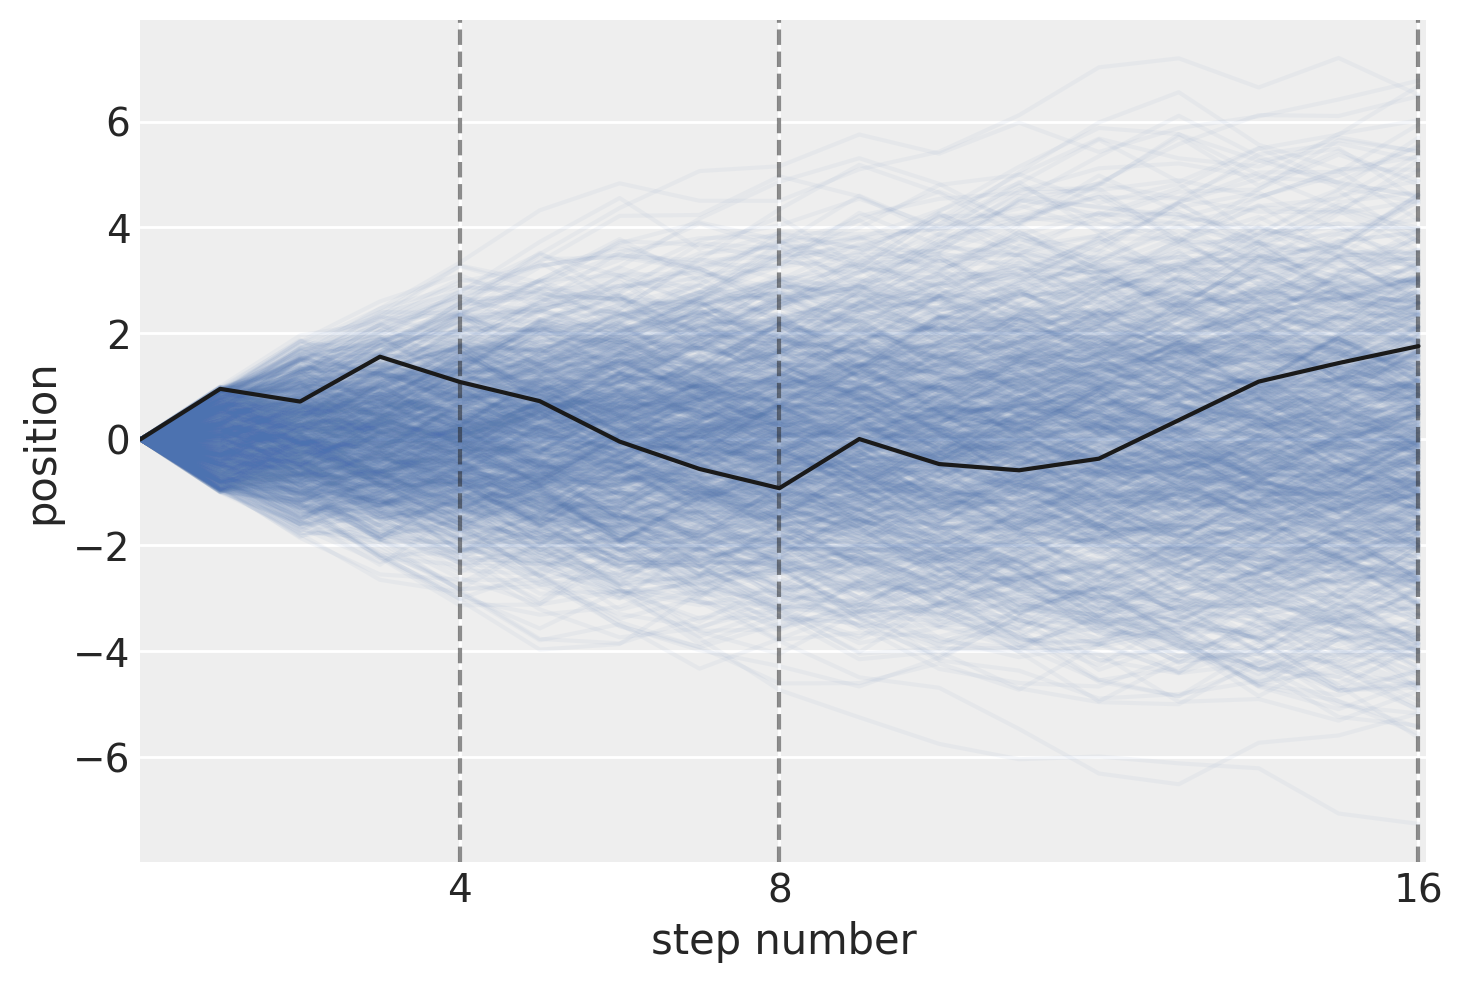

In [91]:
step_rng = np.random.default_rng(1234) # Inatializes a random number generator object.

steps = 16 # The number of steps/round/coin flips per simulation
repetitions = 1000 # Number of random walk simulations to generate
show_steps = [4, 8, 16] # The points at which there will be a vertical line drawn on the graph.
x = np.zeros([steps + 1, repetitions])
for i in range(x.shape[1]):
    x[1:, i] = np.cumsum(step_rng.uniform(-1, 1, steps)) #Simulates coin flips. Columns 1 down are filled with cumulative sum of steps uniformly distributed with random numbers generated from the RNG.

fig, ax = plt.subplots()
plt.plot(range(0, steps + 1), x[:, :], c="b", alpha=0.05)
plt.plot(range(0, steps + 1), x[:, 0], c="k") # Plots the path of the first random walk.

for step in show_steps:
    plt.axvline(step, linestyle="--", c="k", alpha=0.5)

plt.xlabel("step number")
plt.ylabel("position")
ax.set_xticks(show_steps)
plt.xlim(0, step + 0.1)
plt.show()

ChatGPT Code Explanation:

The code above generates random walks using a random number generator and plots the resulting paths. The code imports several libraries: `arviz` and `pymc` are libraries for probabilistic modeling, `matplotlib` is a plotting library, `numpy` \[and `scipy`\] is a library for scientific computing.

The code initializes a random number generator object using the `np.random.default_rng()` function from the numpy library. This random number generator will be used to generate uniformly distributed random numbers between -1 and 1, which will be used to simulate coin flips.

The `steps` variable specifies the number of steps in each random walk, and the `repetitions` variable specifies the number of random walks to generate. The `show_steps` variable is a list of step numbers at which the code will draw vertical lines on the plot.

The code then creates a two-dimensional NumPy array called `x` with `steps + 1` rows and repetitions columns. The first column of this array is filled with zeros, and the remaining columns are filled with the cumulative sum of steps uniformly distributed random numbers generated by the random number generator. This array will be used to store the positions of the random walk at each step.

Next, the code creates a figure and an axes object using the `plt.subplots()` function from `matplotlib`. The code then uses the `plt.plot()` function to plot all of the random walks in the `x` array, with a small transparency (alpha) applied to each line to make them slightly see-through. The code also plots the first random walk in black, and uses the `plt.axvline()` function to draw vertical lines at each step number in the `show_steps` list.

The code then sets the x and y-axis labels using the `plt.xlabel()` and `plt.ylabel()` functions, and sets the x-axis tick marks using the `ax.set_xticks()` function. Finally, the code sets the x-axis limits using the `plt.xlim()` function and displays the plot using the `plt.show()` function.

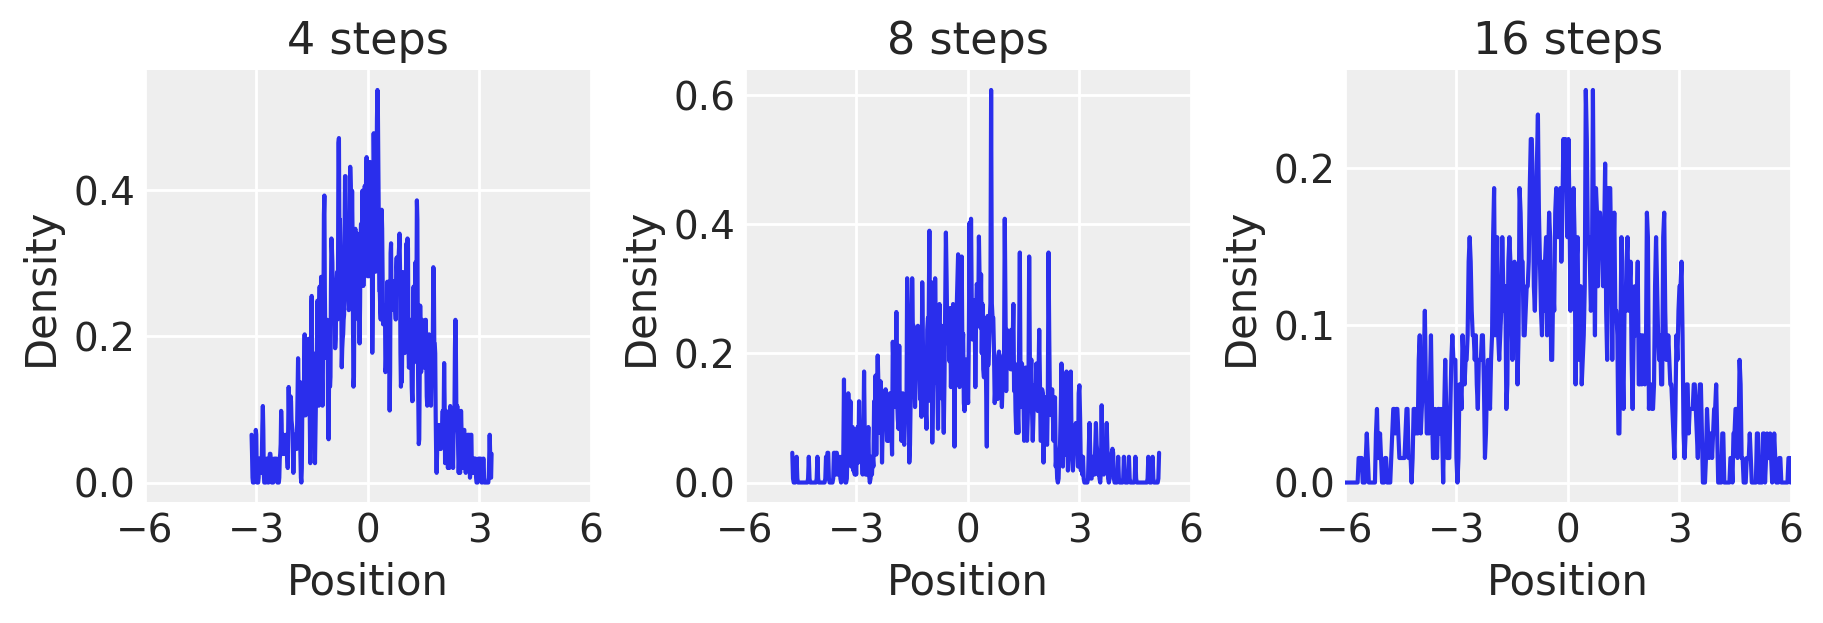

In [92]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True)

for step, ax in zip(show_steps, axs):
    az.plot_kde(x[step, :], bw=0.01, ax=ax)
    ax.set_title(f"{step} steps")
    ax.set_ylabel("Density")
    ax.set_xlabel("Position")
    ax.set_xlim(-6, 6)
    ax.set_xticks([-6, -3, 0, 3, 6])

The plot in Figure 4.2 visualizes the distribution of steps away from the halfway line after 4, 8, and 16 coin flips/steps. What's noticeable is that as we progress in the number of steps, the densities begin to resemble the bell curve associated with Gaussian distributions.

One way to rationalize the Gaussian distribution of the plots is to think of averages. Whatever the average value of the source distribution, each sample from it can be considered a fluctuation from that average value. However, when we add these fluctuations together, they cancel out one another. And in doing so, these fluctuations eventually converge to the mean of the collective observations.

It doesn't matter what the shape is of the underlying distribution. Depending on the shape, the cumulative sums will inevitably converge on the mean, some distributions more slowly than others.

#### Code 4.1

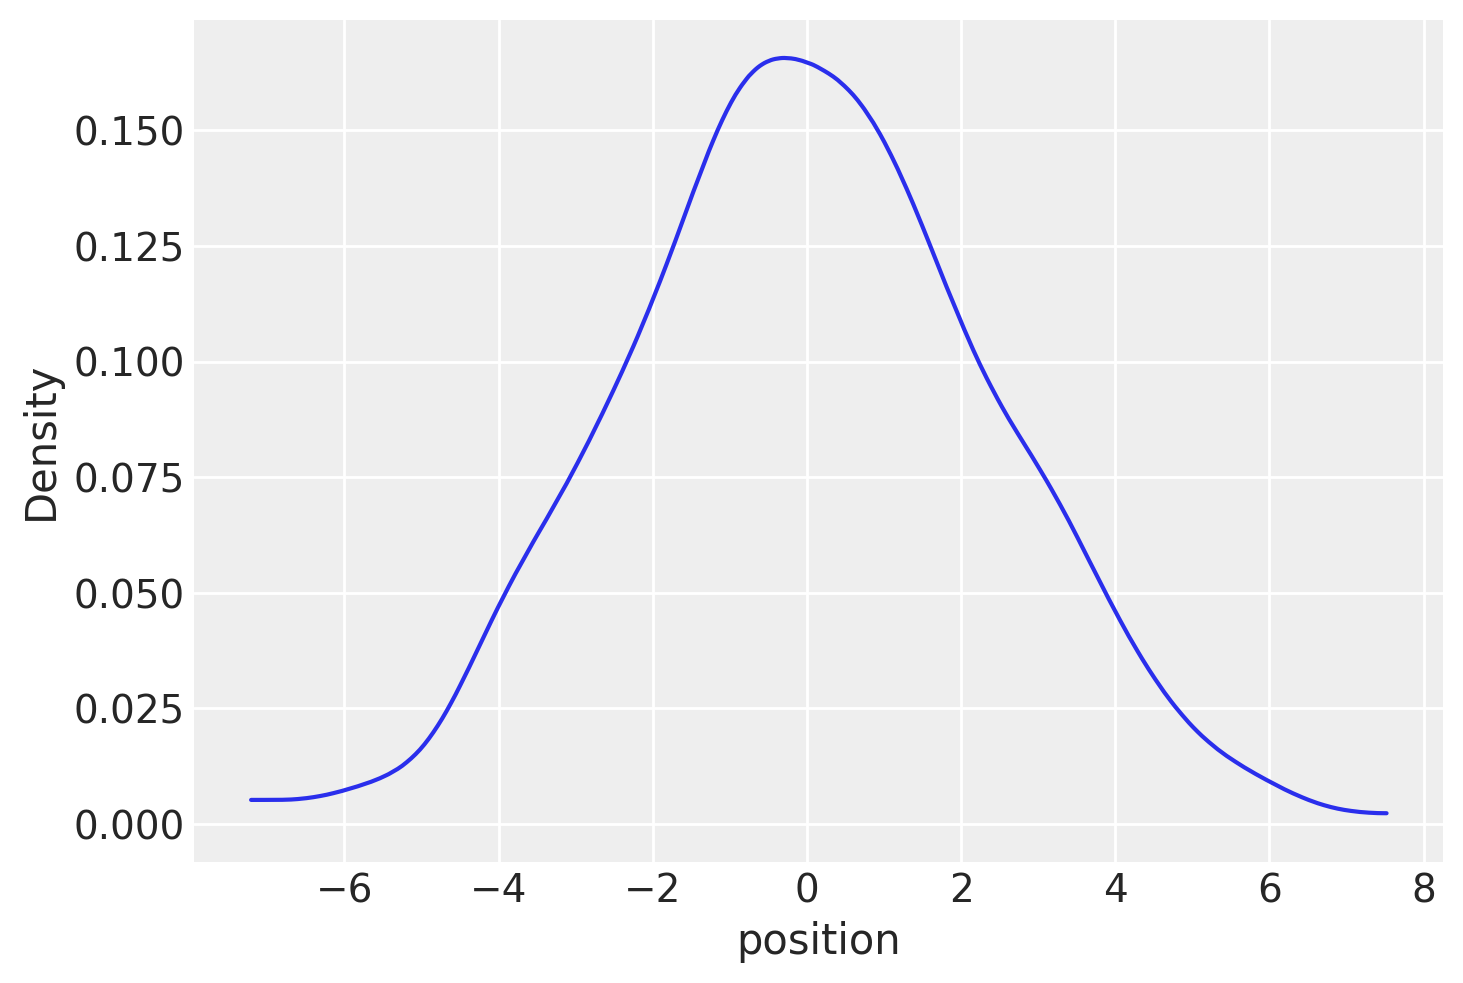

In [93]:
pos = rng.uniform(-1, 1, size=(16, 1000)).sum(0) # Generates a random uniform distribution of numbers between -1 to 1 that's 16 by 1000.
# `sum(0)` adds up each row so that we end up with an array of 1000 values.
az.plot_kde(pos)
plt.xlabel("position")
plt.ylabel("Density");

### 4.1.2. Normal by multiplication.



#### Code 4.2

In [94]:
# Code to sample a random growth rate which samples 12 random numbers between 1.0 and 1.1.
# Each number represents a proportional increase in growth. For example, 1.0 represents no growth while 1.1 represents a 10% growth.
# `prod()` then multiplies all 12 numbers across a single row and returns them as an output.
# The resulting output will be an array of 10,000 values.
pos = rng.uniform(1, 1.1, size=(12, 10000)).prod(0)
az.plot_kde(pos);

#### Code 4.3
##### And experimenting with ChatGPT

ChatGPT's Python interpretation and explanation of Prof. McElreath's code snippet:

```
growth <- replicate( 10000, prod( 1 + runif(12, 0, 0.1) ) )
dens( growth, norm.comp=TRUE )
```

ChatGPT:
The code generates 10000 random samples of growth rates using a uniform distribution, calculates the product of those growth rates, and then plots the density of the resulting growth values using a Gaussian kernel density estimate (KDE).

<Axes: >

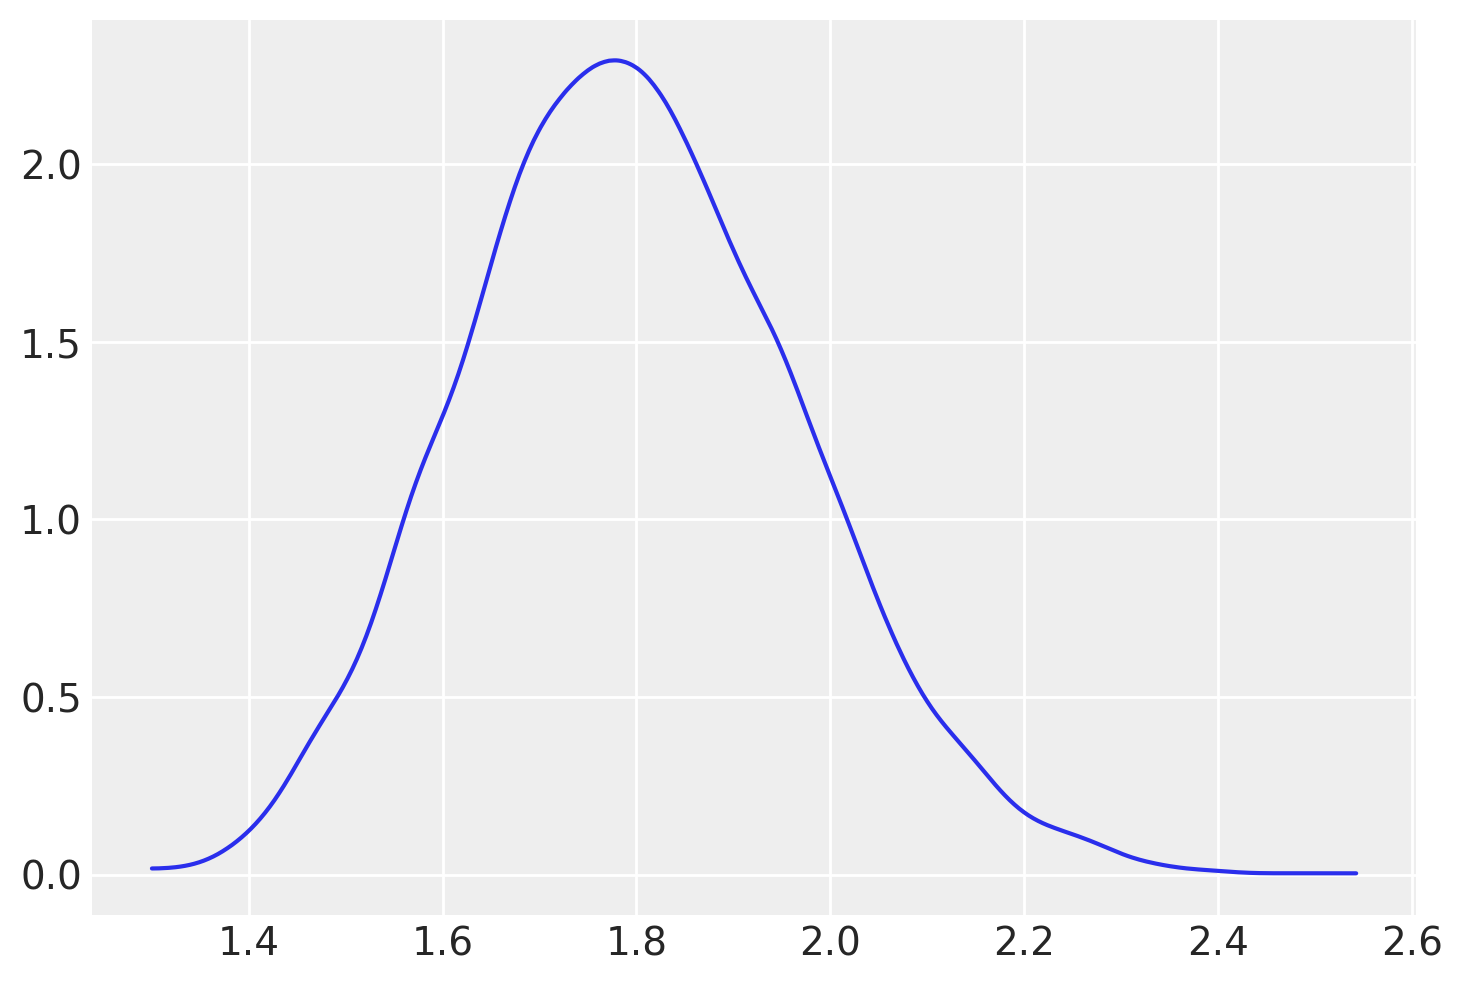

In [95]:
growth = np.prod([1 + np.random.uniform(0, 0.1, size=12) for _ in range(10000)], axis=1)
# stats.kde.gaussian_kde(growth, True) --This was a ChatGPT suggestion.
az.plot_kde(growth) # My code

#### Code 4.4

The smaller the changes we observe amongst a given variable of interest, the closer that product of an array will resemble a Gaussian distribution. Multiplying small numbers is approximately the same as addition.

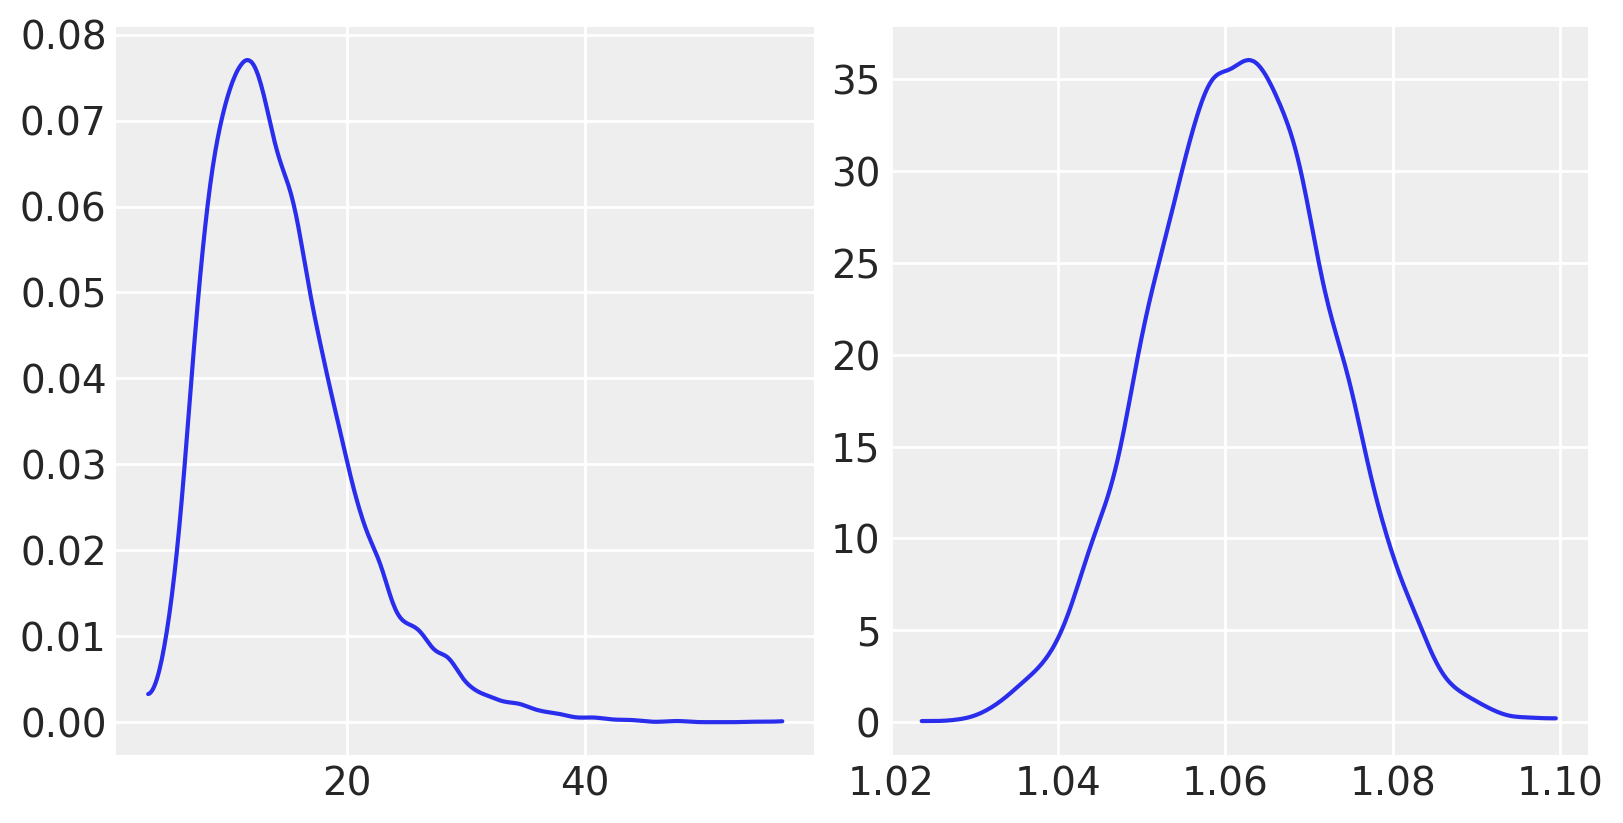

In [96]:
big = rng.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = rng.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

### 4.1.3. Normal by log-multiplication transformations.

When there are large deviations between a set of numbers, their product does not usually result in a Gaussian distribution. However, when they are multipled on a log scale, we'll find a Gaussian distribution as a result.

What does it mean to log-multiply? Let's revisit them.



##### **Reviewing natural logarithms**:

- **Euler's number**: $e = 2.71828182845...$
- **Logarithmic function** are simply an inverse way of calculating the exponent in an exponential function: $2^x = 4 = log_{2}4$
- **Natural logarithms** are a common log base that's usually written as $log_{e}x \rightarrow e^x$. Therefore, when we're trying to find the natural log of a number $ln$, using functions like `np.log(x)`, the result will be the exponent that must be <u>exponentiated</u> to Euler's number $e$.

<ul>
  <ul type="i">
  <li> For example, let's say the number we're evaluating for is $y = 5$. If we plug in <code>np.log(5)</code>, this equates to $log_{e}y \rightarrow log_{e}5 \rightarrow ln(5) \rightarrow e^x = 5$.
  <li>As a result, <code>np.log()</code> will return $x$.
  <li> And if $x = 1.609...$ then that means that $e^{1.609...} = ~5$
  </ul>
</ul>

#### Code 4.5

*Adding logs is equivalent to multiplying the original numbers.* So, if we measure the outcomes of our observations on a log scale, then even multiplicative iterations of large deviations can produce Gaussian distributions. Converting numbers to a log scale is not unusual because, for example, data contained in sound, earthquakes, and even information are often shown in a log scale.

In [97]:
uniform_dist = rng.uniform(1, 1.5, size=(12, 4))

print(f"An example of a randomly generated, uniform distribution of 'growth rates' between 1.1 to 1.5: \n {uniform_dist} \n\n \
The result when each columm in the normal distribution is added up: {uniform_dist.sum(0)} \n\n \
The result when when each columm in the normal distribution is muliplied: yi = {uniform_dist.prod(0)} \n\n \
And the result when when each columm in the normal distribution is transformed through log-multiplication (i.e. evaluating for xi: e^xi = yi ): \n xi = {np.log(uniform_dist.prod(0))}"
)

An example of a randomly generated, uniform distribution of 'growth rates' between 1.1 to 1.5: 
 [[1.13639216 1.31101335 1.10052595 1.33551546]
 [1.43171832 1.42604913 1.08663362 1.15442315]
 [1.39168314 1.42609504 1.06584281 1.16232293]
 [1.38055203 1.34477991 1.21968901 1.06035138]
 [1.48573158 1.20420618 1.30794713 1.07005004]
 [1.31170739 1.1307393  1.2294594  1.04724032]
 [1.13445775 1.40456042 1.49161917 1.25450748]
 [1.18270549 1.1848609  1.18632029 1.00408864]
 [1.35837974 1.32009492 1.45656844 1.02419897]
 [1.12400031 1.36655136 1.18695219 1.26766171]
 [1.13460229 1.39874207 1.13165092 1.1801281 ]
 [1.22719438 1.06191852 1.10916776 1.03394707]] 

 The result when each columm in the normal distribution is added up: [15.29912458 15.57961109 14.57237669 13.59443524] 

 The result when when each columm in the normal distribution is muliplied: yi = [17.37664214 21.77069852  9.59983644  4.24914422] 

 And the result when when each columm in the normal distribution is transformed thr

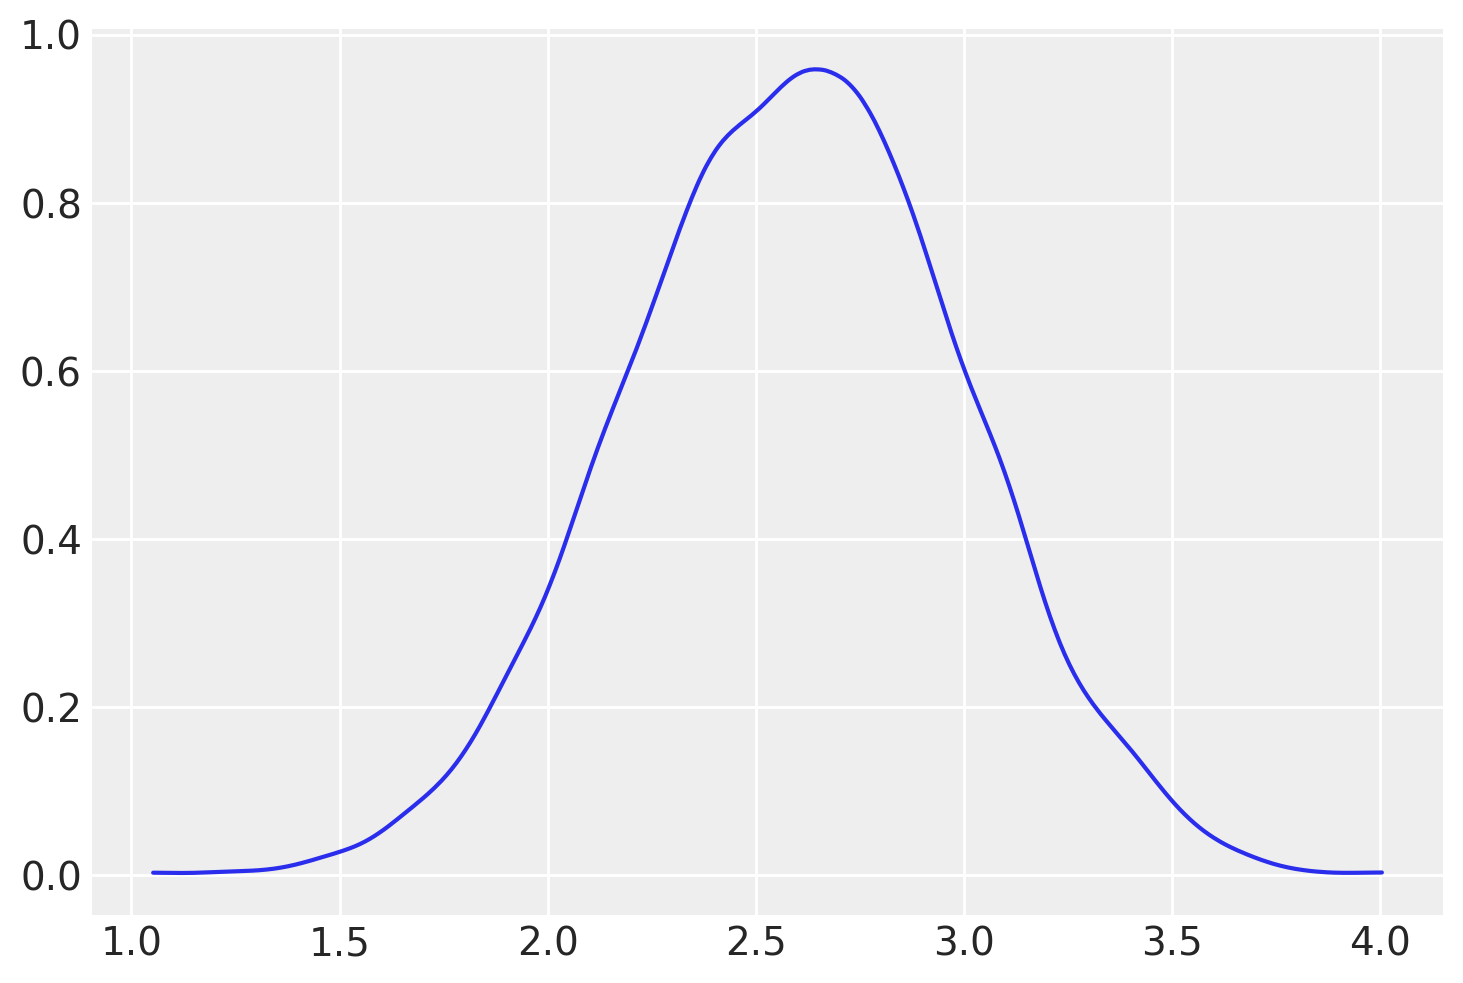

In [98]:
log_big = np.log(rng.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big);

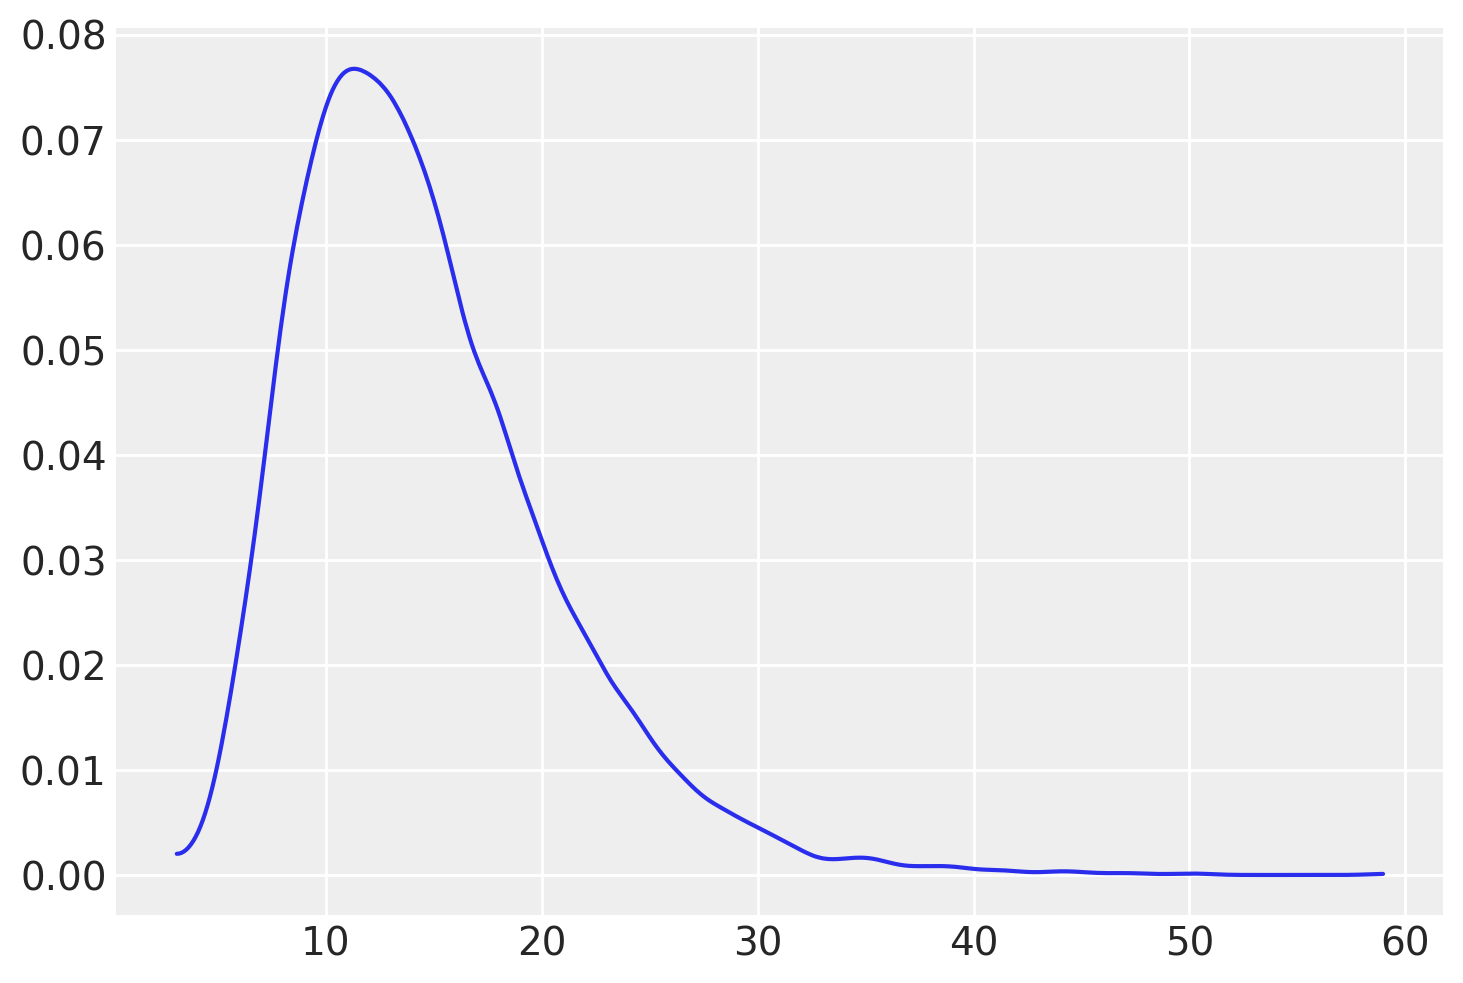

In [99]:
# Comparing what the distribution would've looked like without converting it to a log-scale.
big = rng.uniform(1, 1.5, size=(12, 10000)).prod(0)
az.plot_kde(big);

### 4.1.4. Using Gaussian distributions.

The rest of this chapter will involve using Gaussian distributions as the foundation for the hypothesis and building up models of measurements for two reasons: ontological & epistemological.

But first, let's detour quickly into the realms of philosophy by reviewing the term "ontology." **Ontology** is a branch of philosophy concerned with *being*. It addresses questions like "How entities are grouped into categories?" And "Which of these entities exist at the most fundamental level?"

Jumping back to Bayesian statistics, the **ontological** justification for using Gaussian distributions is it's widespread throughout the natural world in various shapes and domains. Things like measurement errors, variations in growth, or the velocities in molecules all tend towards Gaussian distributions because these processes add together fluctuations. And if we repeatedly add finite fluctuations, it will result in a distribution of sums that have shed all information about the underlying process, besides their mean and the spread.

As a quick aside, Gaussian distributions are a member of a family of fundamental natural distributions known as the **exponential family** which all populate the natural world.

Again, let's delve back into the philosophy of **epistemology** which is the study of knowledge and addresses questions such as "What does it mean to say that we know something?" Or "What separates truth from beliefs or justified beliefs?"

By the **epistemological** justification, Gaussian distributions represent a particular state of ignorance. That is to say, if all we are willing to assume is that a measure has a finite variance, then the Gaussian distribution is the shape that can be realized in the largest number of ways because it doesn't introduce new assumptions. If you don't think that the distribution in your data should be Gaussian, then that implies that you know something else that you should include in your model to improve inference. The epistemological justification is premised on **information theory** and **maximum entropy**.




### **Overthinking: Gaussian Distribution**

To demystify a **Gaussian distribution**, note the following equation below where:
- $p(x) =$ *probability density* of some value of $x$. A **[probability density function](https://youtu.be/hDjcxi9p0ak)**  is a distribution with *continuous* outcomes, unlike a distribution with discrete outcomes (such as a binomial), which are associated with **[probability mass functions](https://youtu.be/hDjcxi9p0ak)**. So remember:
  1. *Probability <u>Mass</u> Function* ($pmf$) $=$ *discrete outcomes*
  2. *Probability <u>Density</u> Function* ($pdf$) $=$ *continuous outcomes*
- $\sigma = $ standard deviation. To represent an entity that's two standard deviations away, we could write $2\sigma$. Similarly, squaring a standard deviation $\sigma^2$ is important because it is used in the formula for the normal distribution.
  - In the formula for the normal distribution, $\sigma^2$ appears in the denominator of the exponent term, which determines the shape of the distribution. The larger the value of $\sigma^2$, the wider and flatter the distribution will be. Conversely, the smaller the value of $\sigma^2$, the narrower and sharper the distribution will be.
- $\mu = $ mean.

$$ p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{\frac{-(x - \mu)^2}{2 \sigma^2}}$$

The important part of this formula is the bit on $(x - \mu)^2$, which gives the normal distribution its fundamental quadratic shape. Once you exponentiate the quadratic shape, you get the classic bell curve. The rest of the equation just scales and standardizes the distribtuion.

## *Section 4.2* - A language for describing models.

What's important here is to learn the <u>strategy</u> behind these models and why we apply them, *NOT their procedures* so that we can build anything we need with the data we have. When approaching a particular problem we're trying to solve, we need to ask a few key questions:

1. What are the outcomes?
2. How are the outcomes constrained? (what is the likelihood?)
3. What are the predictors, if any?
4. How do the predictors relate to the likelihood?
5. What are the priors?

Scientists increasingly use a standard language for describing and coding statistical models in nearly ALL statistical journals. In addition, this language for **applied statistics model notation** will be able to answer all the questions we just listed in a standard, uniform way regardless of the problem. Learning this language is a requirement! The following is an introduction to the principles for describing models in scientific colloquial:

1. Scientists recognize a set of variables to work with which are sometimes observable. These are called **data**.
  <ol type="a">
  <li> Unobservable phenomena that result from the data, such as averages, are defined as <b>parameters</b>.
  </ol>
2. Scientists define each variable in terms of other variables or a probability distribution.
3. The combination of variables and their probability distributions define what's called a **joint generative model** which can be used both to simulate a hypothetical observation, as well as analyze real ones.

This language applies to models across all fields, from astronomy to art history. The biggest difficulty lies in the subject matter - which variables matter, and how does theory tell us to connect them? Not in the mathematics. Once a scientist gets comfortable with this language, it becomes easier to communicate the assumptions of a model. We won't have to remember words like *homoscedasticity* (which means constant variance), because we can just read the conditions from the model definitions.

We will also be able to see natural ways to change these assumptions, instead of feeling trapped within some procrustean (which means to enforce uniformity without regard to individuality) model types, like regression or ANOVA. These are all the same kind of model, and the fact becomes more obvious once we know how to talk about models as *mappings of one set of variables through a probability distribution onto another set of variables*.

### 4.2.1. Re-describing the globe-tossing experiment.

Recall the following variables for our model in the globe-tossing experiment conducted in Chapter 2:
- $W \sim Binomial(N , p$)
- $p \sim Uniform(0, 1$)

The first line, $W \sim Binomial(N, p$), can be read as: "The count of $W$ (which is also known as our *outcome variable*) is distributed **binomially** (the likelihood) with a sample size of $N$ and a prior probability of $p$" (which both serve as the model's parameters)

The second line, $p \sim Uniform(0, 1$), can be read as: "The prior for $p$ (which is the parameter we want to estimate) is assumed to be distributed *uniformly* (which is our prior distribution) between $0$ and $1$."

The language on the left-hand side allows us to know all of a model's assumptions right away. We'll know that the binomial distribution assumes that each sample (globe toss) is independent of the others. We also know that the model assumes that the sample points are independent of one another, which is an inherent quality of a binomial distribution.

<img src="http://drive.google.com/uc?export=view&id=1_aETGqVrcX77585zwptBMYoXPZK2l6mf" height=400 width=600>

Another important observation in the model description above is that the *first line* describes the **likelihood** function used in Bayes' Theorem. The *second line* defines the model's priors.

Remember the following representations of **likelihood functions** (some specifically for Binomial distributions):

$P(E|H)$ OR `stats.bimom.pmf()` OR $Pr(w, l \mid p) = \frac{N!}{w!(N − w)!} p^w (1 − p)^{N−w}$.

It's also important to note that the symbol "$\sim$" in both lines of this model can be read as "is distributed as" and indicates that this model has a **stochastic relationship** between it's parameters and its distribution. More specifically, a model can be described as **stochastic** *when the mapping between parameters and the distribution is <u>probabilistic</u> where some values in the parameter/variable (such as $W$ or $p$ on the left-hand side) are more plausible than others*. However, these variables don't often represent just a single number, but instead a distribution of values.

Later on, we'll provide examples of models with more *determenistic* values in them.

#### Code 4.6

**Overthinking: From model definitions to Bayes' Theorem**

The mathematical format with the **model's definitions** above can also be used to define the posterior distribution using **Bayes' Theorem**:

$Pr(p \mid w, N) =  \frac{Binom(w \mid p, N) \cdot Uni(p \mid 0, 1)}{\int Binom(w, l \mid p) \cdot Uni(p \mid 0, 1) \cdot dp} $

This equation is also expressed in the Code 4.6 cell below:

Text(0, 0.5, 'Density')

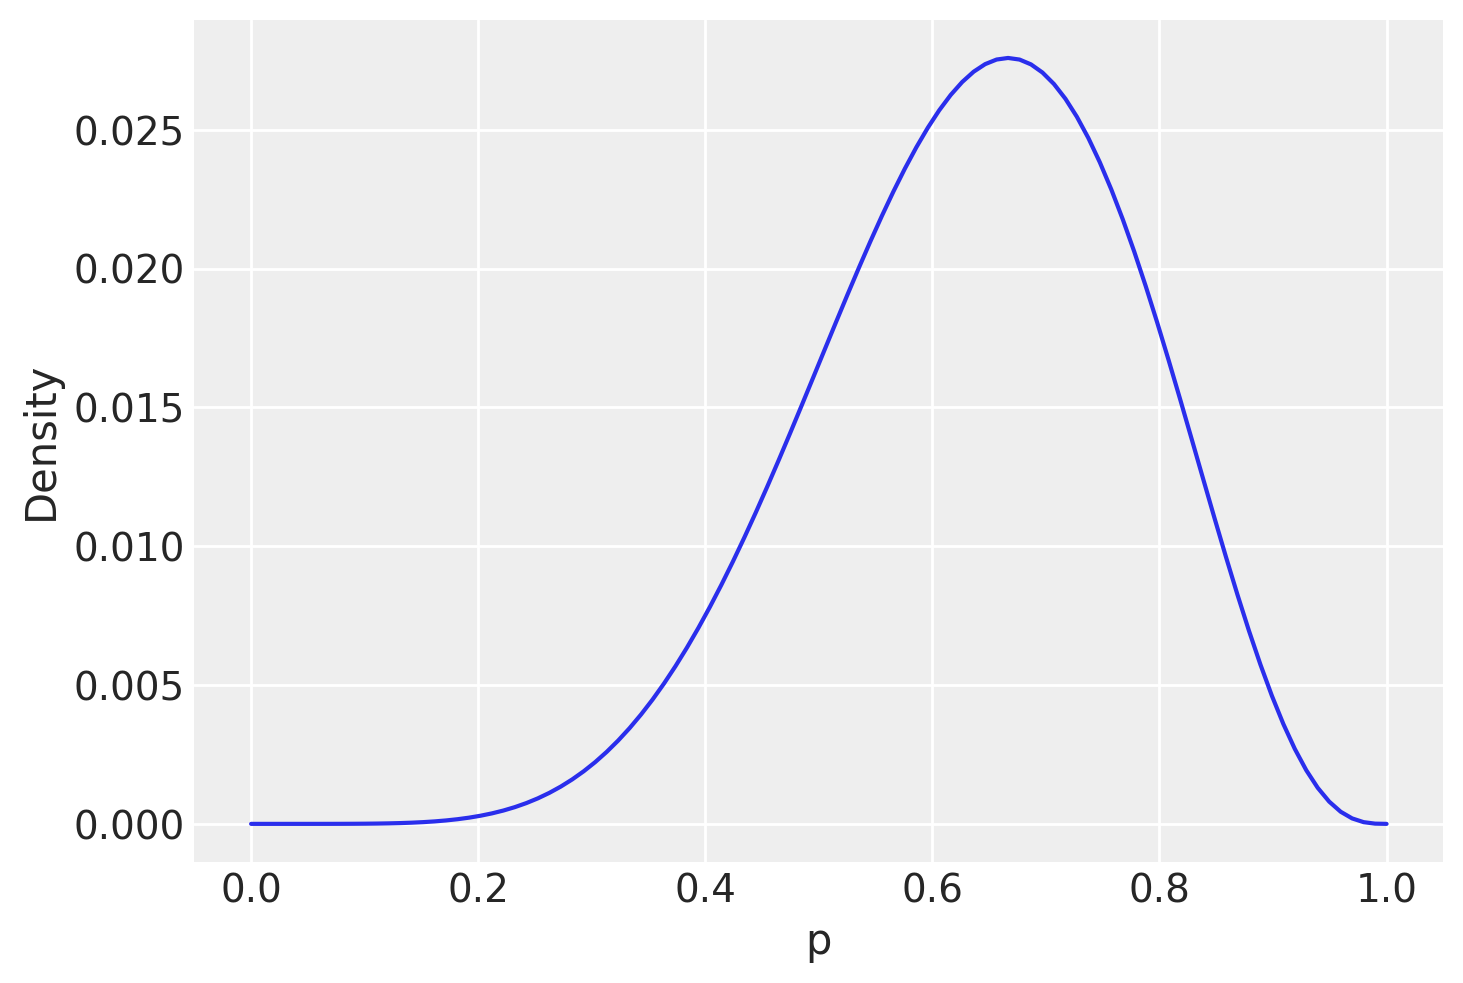

In [100]:
# Difference between the past "binom_post_grid_approx" function we created:
# uniform_prior(func): np.repeat(5, grid_points=100) | ## Previous func: stats.uniform.pdf(p_grid, 0, 1))
# unstd_posterior (var): likelihood * uniform_prior

## The biggest difference was how the uniform prior was calculated but there isn't much difference here.
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior)
plt.xlabel("p")
plt.ylabel("Density")

## *Section 4.3* - Building a Gaussian model for the heights of the !Kung San population

Now that we've covered the language of statistical models, let's build the scaffolding for a linear regression using a single variable to model as a Gaussian distribution. We'll then use Bayesian updating to allow us to consider every combination of values for our 2 parameters which describe the distribution's shape, the mean $\mu$ and the standard deviation $\sigma$, and rank them by their relative plausibility (i.e. their posterior probabilities) in light of the data. Keep in mind that the result that we're aiming for is the entire posterior distribution (not single point estimates) of the Gaussian distribution. Yes, it does sound counterintuitive, but we are trying to get a distribution of distributions.

We'll be using the partial census data for the !Kung San people stored in the "Howell" csv file to model their population heights. To provide more context, the !Kung San population in the Dobe area is a unique group of people who continues to forage well into the 21st century, despite the advances in technology we've observed over the past few decades. With this dataset, we can demonstrate regression problems from a Bayesian perspective.

#### Code 4.7

In [101]:
# d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
# d.head()

# ALTERNATE CODE IF YOU HAVEN'T DOWNLOADED THE DATA
path = "https://raw.githubusercontent.com/pymc-devs/pymc-resources/main/Rethinking_2/Data/Howell1.csv"
d = pd.read_csv(path, sep=";", header=0)

#### Code 4.8

In [102]:
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

#### Code 4.9

There are 4 variables in our dataset: `height` (measured in cm), `weight` (measured in kg), `age` (yrs), and `male` (0=No/1=Yes). For now, we will predict the height variable from all the other variables we've collected information from each person (row) in our dataset.

In [103]:
az.summary(d.to_dict(orient="list"), kind="stats")

mean      sd  hdi_5.5%  hdi_94.5%
height  138.264  27.602    90.805    170.180
weight   35.611  14.719    11.368     55.707
age      29.344  20.747     0.000     57.000
male      0.472   0.500     0.000      1.000

array([[<Axes: title={'center': 'height'}>,
        <Axes: title={'center': 'weight'}>],
       [<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'male'}>]], dtype=object)

<Figure size 100x100 with 0 Axes>

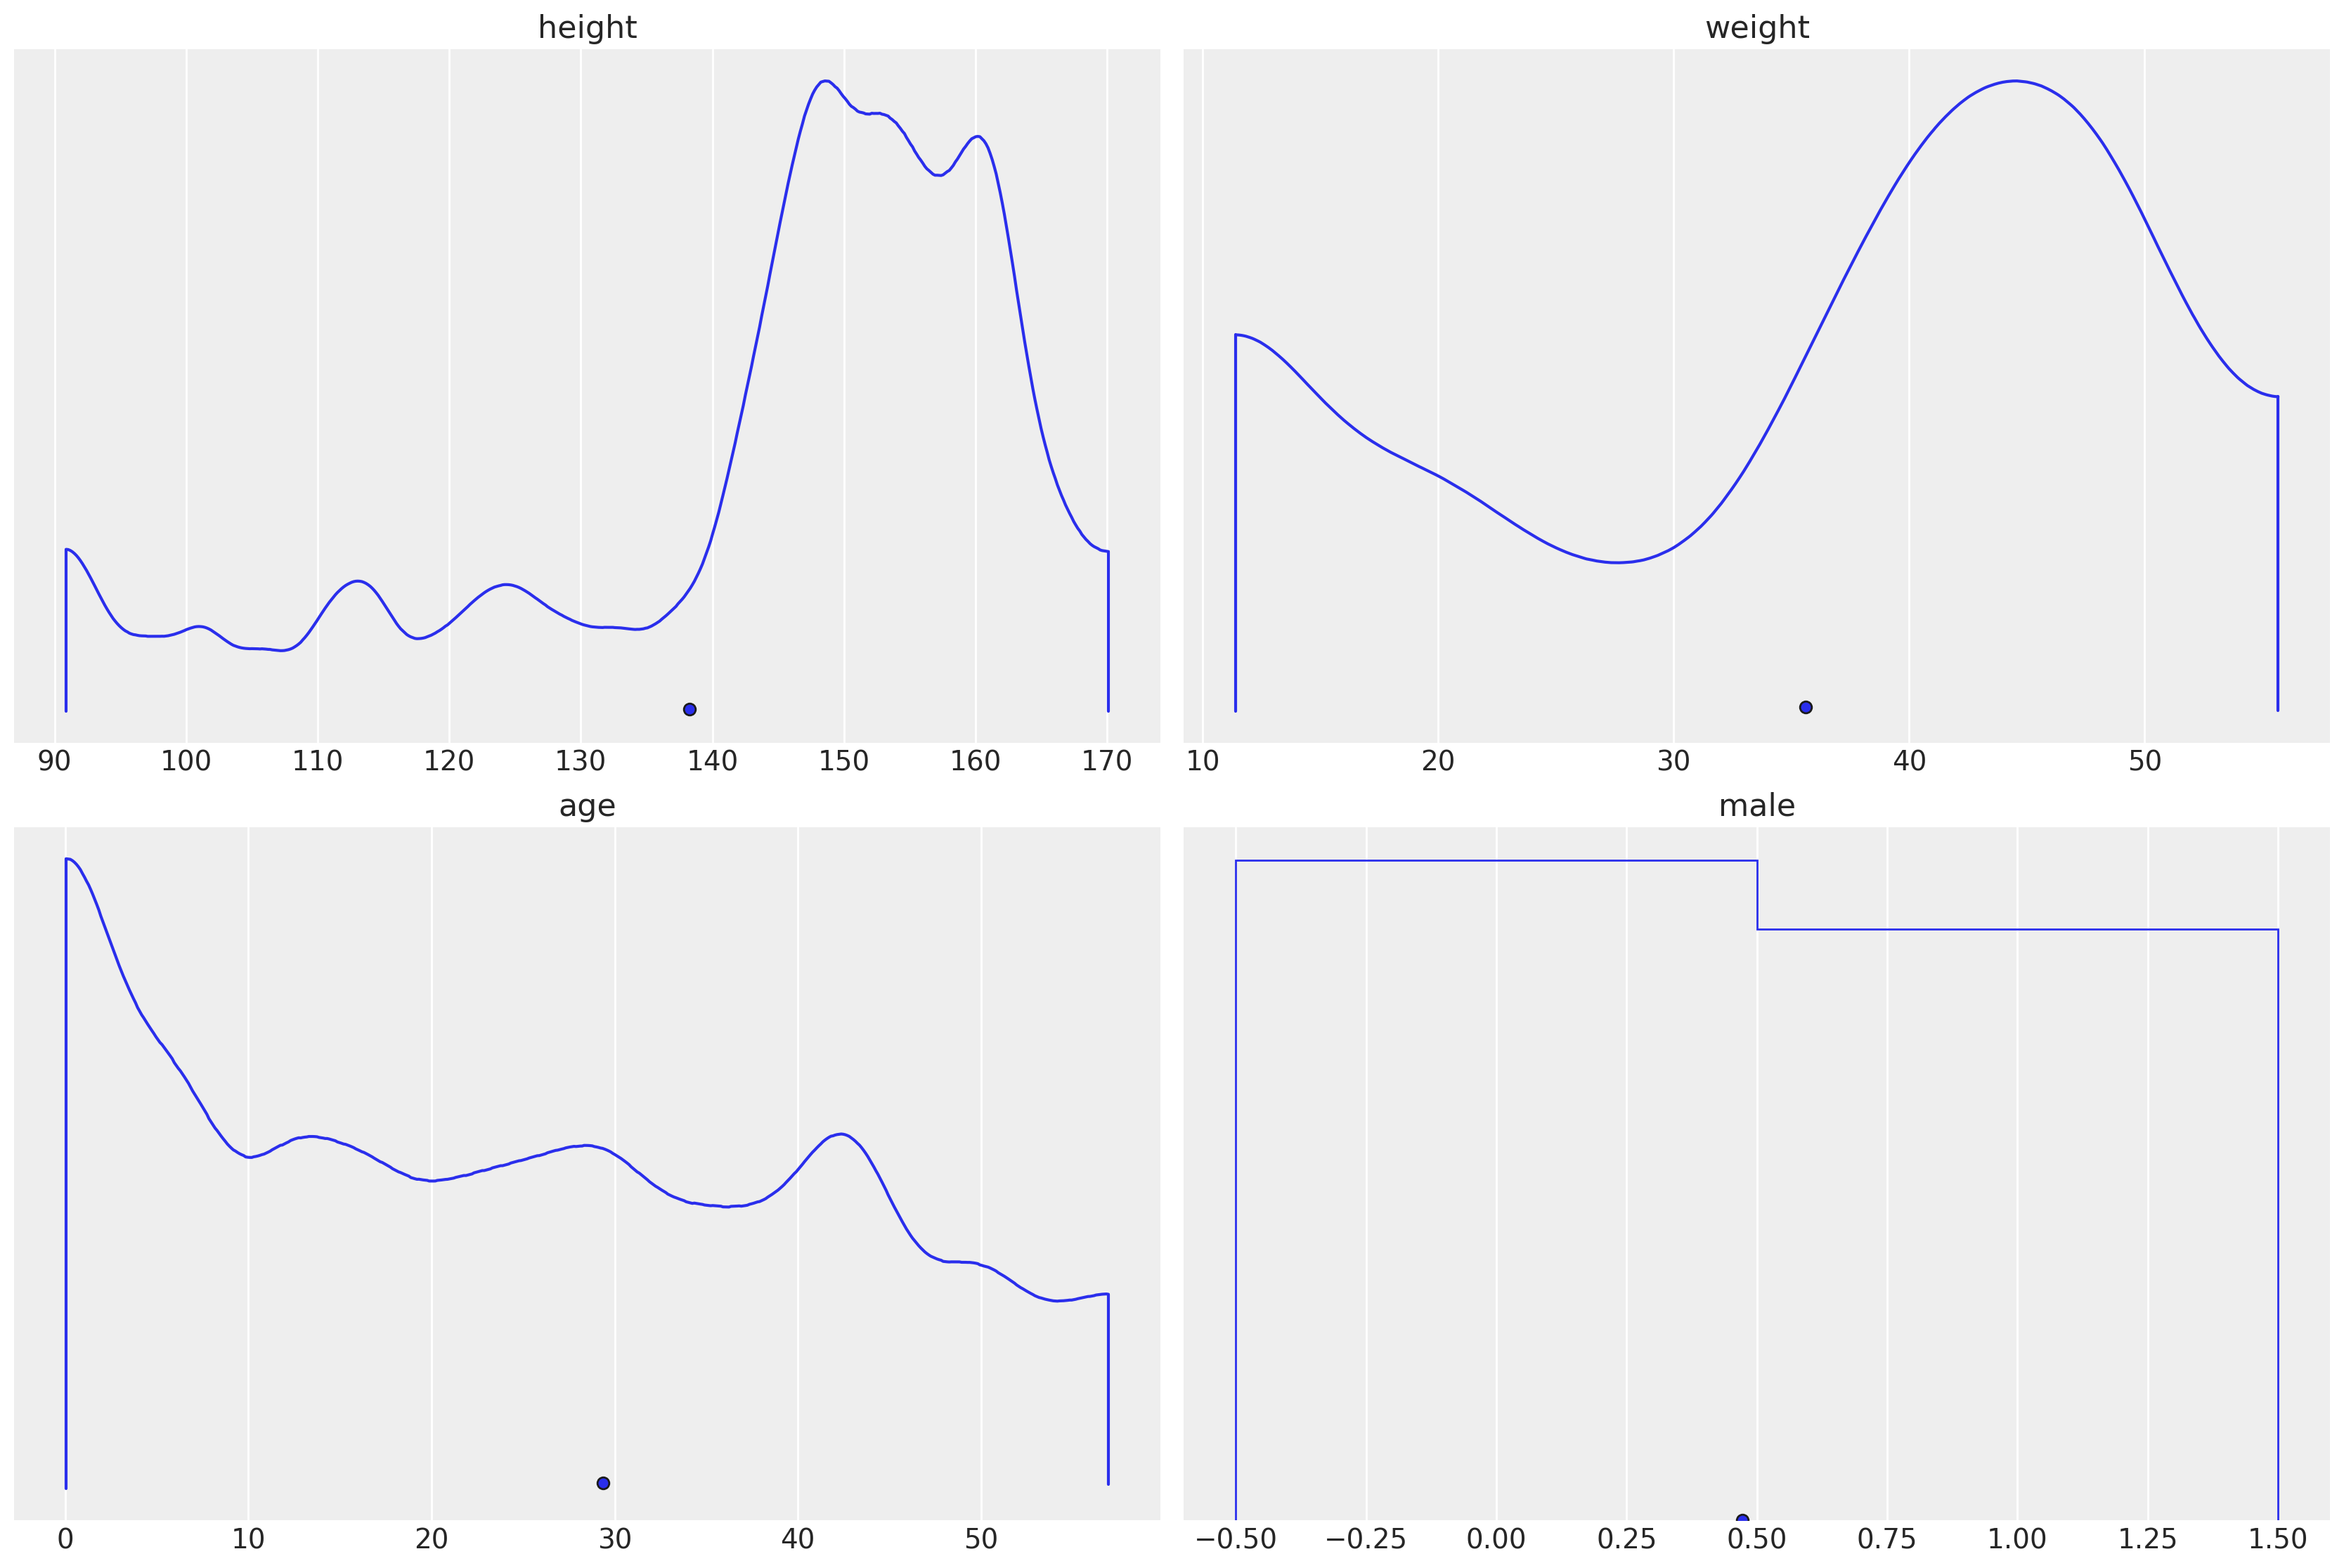

In [104]:
# Set the size of the plots
plt.figure(figsize=(1, 1))

# Code to include the histogram that was generated in the book:
az.plot_density(d.to_dict(orient="list"), grid=(2, 2))

Let's start things off by building a model for the distribution of height data:

- $h_{i} \sim Normal(\mu, \sigma)$

Let's also add some priors to the model:

- $\mu \sim Normal(178, 20)$
- $ \sigma \sim Uniform(0, 50)$:

#### Code 4.10

In [105]:
# Our target variable
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

#### Code 4.11

Since we know that age is heavily correlated with height since the older people get, generally the taller they become until they reach biological maturity, which is often around 18 years of age for most people. Therefore, let's use the code in 4.11 to filter our data so that it ONLY INCLUDES adults.

In [106]:
d2 = d[d.age >= 18]

### 4.3.2. The model.

Remember that our goal is to model the height of !Kung San population, so if we plot our distribution of height data, we'll find that these values are normally distributed. One hypothesis for this is that height is a sum of small growth factors which tend to converge to a normal distribution since these factors will affect everyone in a Gaussian manner.

Although it may be reasonable to adopt a Gaussian distribution, it's bad practice to assign the distribution type to raw data! The data could be a mixture of different Gaussian distributions (of which there are countless of) so we can't just know its distribution by simply eye-balling the distribution of outcomes. However, we must also remember that empirical distributions don't actually need to be Gaussian to justify using a default Gaussian probability distribution.

To define a model with heights $h_{i}$ as normally distirbuted with a mean $\mu$ and a standard deviation $\sigma$, we can write:

$h_{i} \sim Normal(\mu, \sigma)$

OR for short:

$h_{i} \sim 𝓝(\mu, \sigma)$

#### Rethinking: Independent and identically distributed

When saying that a model is "normally distributed," it often carries the assumption that each value, represented by $h_{i}$ which is an individual person's data ($h$ by itself symbolizes the entire distribution of heights), is **independent and identically distributed (i.i.d)**. You might even see the model written as:

$h_{i} \overset{iid}{\sim} 𝓝(\mu, \sigma)$

However, if we reflect on our data, we'll know this assumption is false because heights amongst family members are at least correlated through shared genes and alleles. Although an i.i.d assumption wouldn't be valid for this dataset, we can keep it the way it is for now in the small world of our golem if we don't have a better way to represent the uncertainty in the distribution. In this instance, we're making an *epistemological* assumption about the data, not an *ontological* or a physical assumption about the world. E.T. Jaynes coined the term **[mind projection fallacy](https://en.wikipedia.org/wiki/Mind_projection_fallacy)** which is the mistake of confusing epistemological claims with ontological claims. In other words, the mind projection fallacy is when someone's subjective thoughts or judgements are "projected" to be the real and inherent properties of that object/person/group/thing.

There are also correlations in a distribution that we can usually assume to be i.i.d but would do little to change the shape of the overall distribution. For example, siblings often have correlated heights which technically breaks our i.i.d assumption. But in reality, we'll still find a normal distribution of heights, granted we have a large enough dataset. In Chapter 9, we can use Markov Chain Monte Carlo to exploit these correlations in a dataset to estimate almost any distribution we like.

We will need priors to complete our models so let's add the joint prior probability for all parameters in our model represented by $Pr(\mu, \sigma)$. In most cases, priors are specified independently for each parameter which we can express as $Pr(\mu, \sigma) = Pr(\mu) \cdot Pr(\sigma)$. Therefore, we can describe our golem by the following:

$h_{i} \sim Normal(\mu, \sigma)$: To be read as: "*The height $h$ of an individual $i$ is distributed normally with a mean $\mu$ and a standard deviation $\sigma$*."

$\mu \sim 𝓝(178, 20)$: "*The average height of the population is normally distributed around 178 cm and with 95% of the population's height falling $\pm 20$ cm of that average height*."

$ \sigma \sim Uniform(0, 50)$ "*The standard deviation is uniformly distributed somewhere between 0 and 50 cm.*"

#### Code 4.12

You might ask: How did we pick the values specified in the priors for the mean $\mu$ (178, 20) and the standard deviation $\sigma$ (0, 50)? Well, in this case, we're adding domain-specific knowledge about the height of our population and using them as our priors. In many countries around the world, the average height can be around 178 cm (or 5'10 ft), which also happens to be the height of the author of this text, Richard McElreath. And if we use 20cm as our standard deviation ($178 \pm 20cm$), this gives us a huge range of values that could represent the average height for a given population (between 138cm/4'6 ft/-$2\sigma$ & 218cm/7'2 ft/+$2\sigma$)! In other words, we're simply representing what's already been expressed in the second line of our model $\mu \sim 𝓝(178, 20)$ which we can read as: *The average height ($\mu$) can be distributed ($\sim$) normally (𝓝) around the value 178 with a standard deviation of 20.*

Now let's plot our priors so that we have a good understanding of the assumptions we've built into our model:

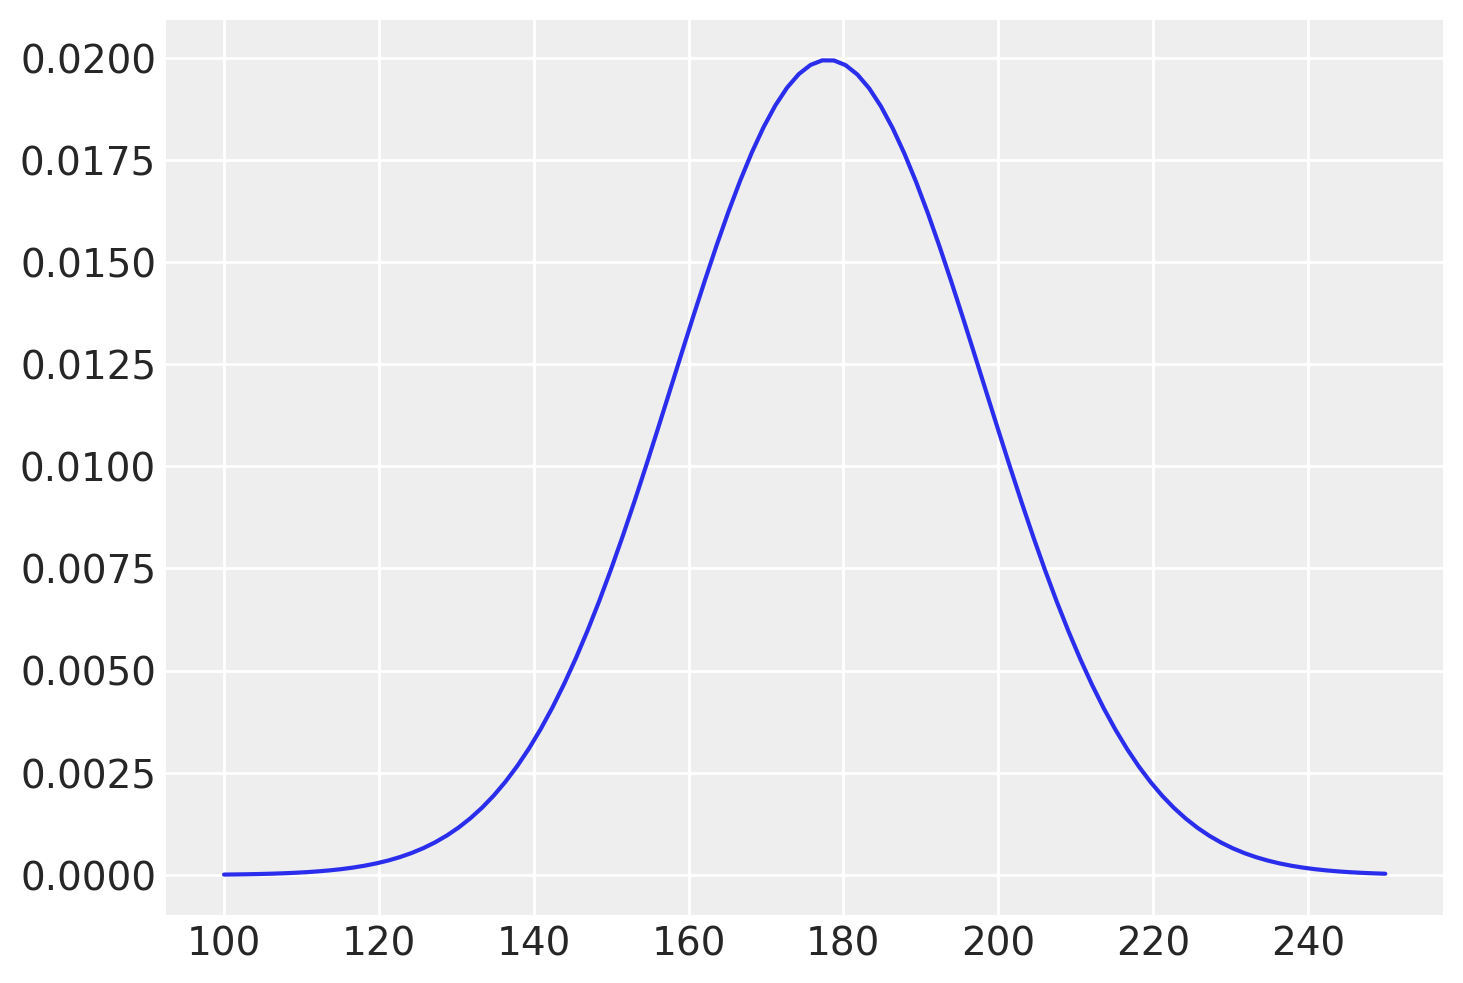

In [107]:
x_mu = np.linspace(100, 250, 100)
plt.plot(x_mu, stats.norm.pdf(x_mu, loc=178, scale=20));

#### Code 4.13

In Code 4.12, we can see that our model assumes that the average height of the *entire* distribution (the graph doesn't represent individual heights) must at least fall between 140 and 220cm, making up roughly 95% of the entire distribution.

As for our prior ($\sigma$), we've specified it to have a uniform/flat shape and is designed to be a restraint for the number of possible values for our distribution's standard deviation (min. is 0, max. is 50). Code 4.13 outlines the shape of our prior for standard deviations: $ \sigma \sim Uniform(0, 50)$

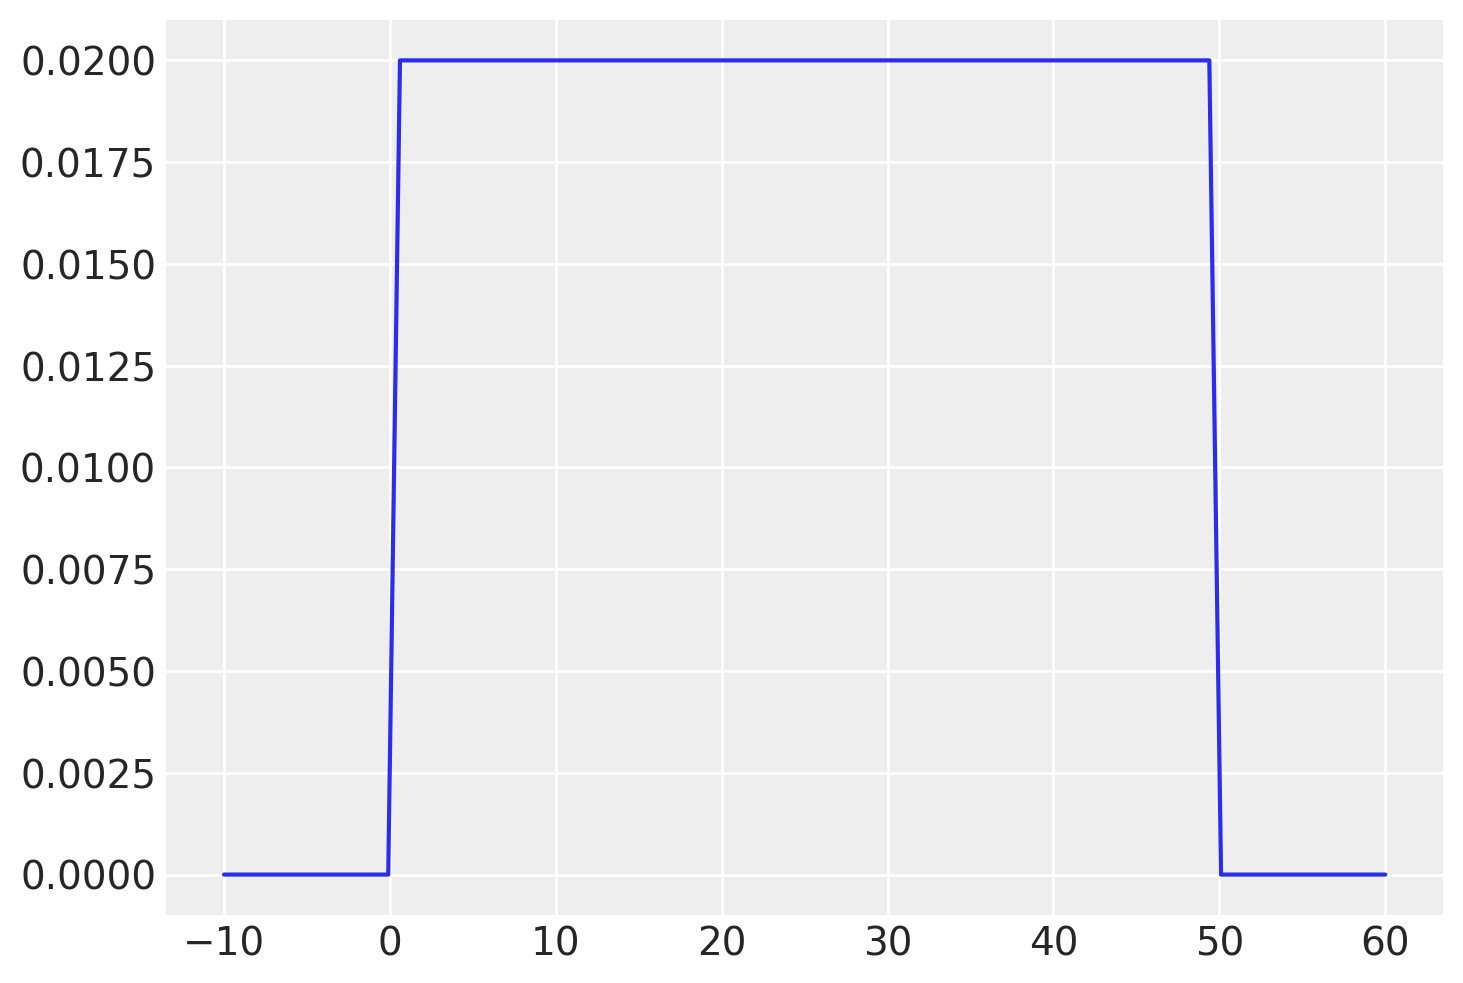

In [108]:
x_sigma = np.linspace(-10, 60, 100)
plt.plot(x_sigma, stats.uniform.pdf(x_sigma, 0, 50));

#### Code 4.14 - Generating a Prior Predictive Simulation

Once we've chosen our priors for $h$, $\mu$, and $\sigma$, we can build **prior predictive simulation** for the values we expect to see about *individual* heights and their associated distribution. This is done by sampling from our prior values using the assumptions we've specified (like we sampled the posteriors in Ch 3 using our prior distributions as our parameters) to *simulate the distribution of heights in our population*. Graphing our chosen prior values can also help us determine if we've made bad choices about these values.

By doing prior predictive simulation, we can force the model to make predictions about the data via priors to see how it "thinks" before it's actually seen the data. Often, not always, but often the models come into this process with ridiculous thoughts, such as humans having negative heights, which is what would happen if it initially starts with flat priors (i.e. we don't give the model any priors).

([], [])

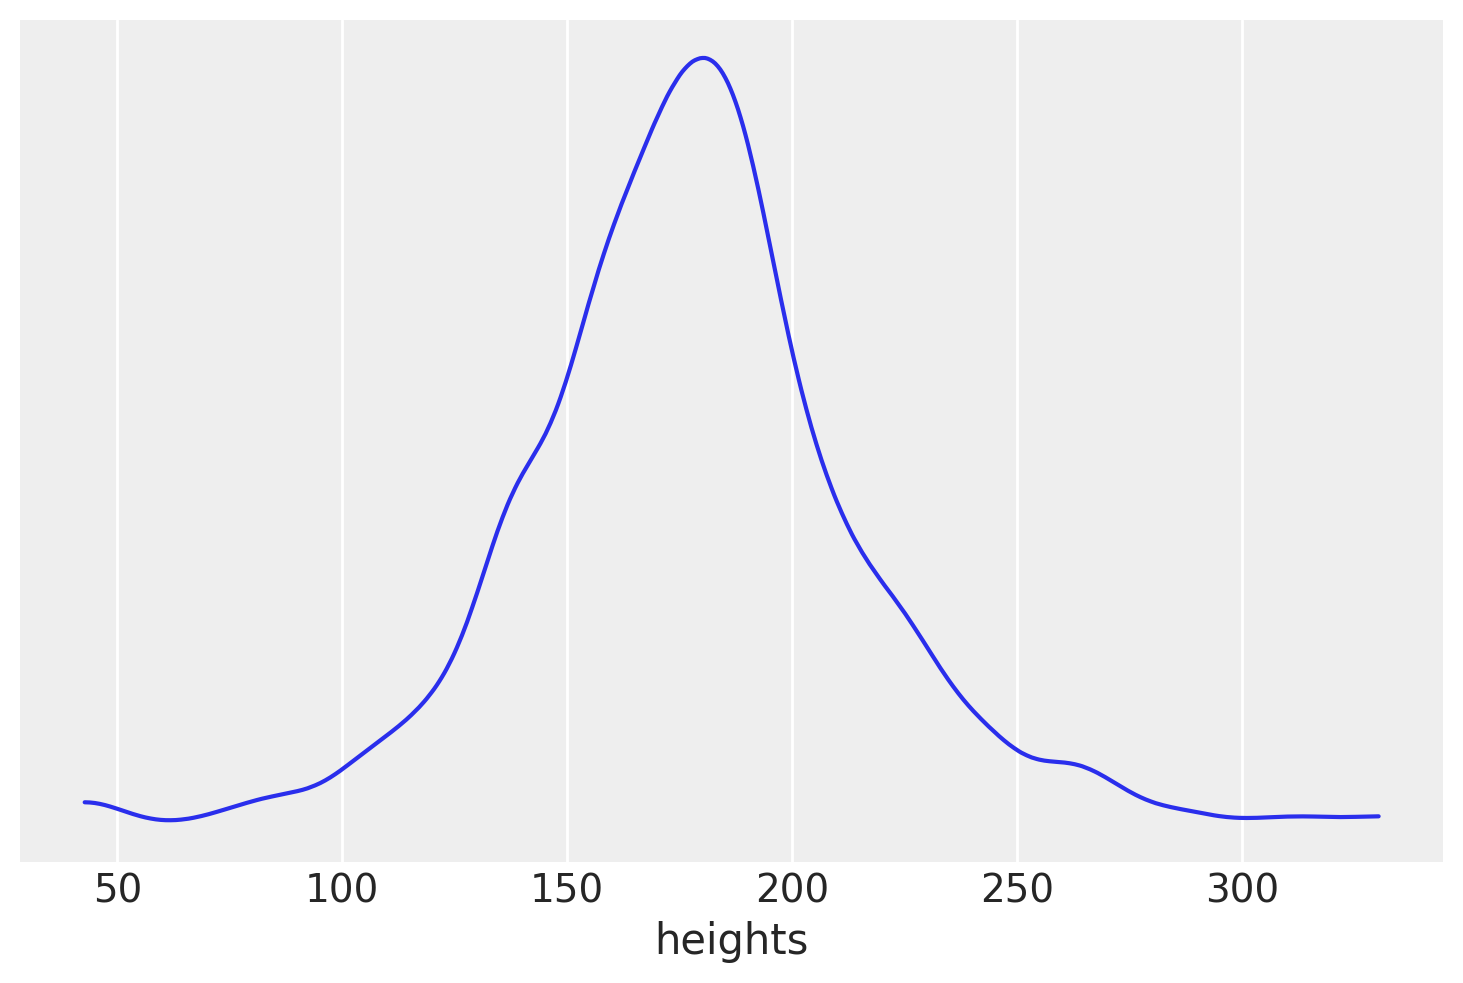

In [109]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples) # Samp'd dist of plausible avg heights of pop
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples) # Samp'd dist of plausible std devs of pop
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma) # Generates a sampled norm dist. of ind. values
az.plot_kde(prior_h) # Creates a kernel density chart
plt.xlabel("heights")
plt.yticks([])

#### Code 4.15

If we look at the distribution of heights in the previous code cell (Code 4.14), we'll find that the distribution is vaguely bell-shaped with thick tails. This graph is the expected distribution of heights averaged over the prior and isn't precisely Gaussian. This is okay because it simply represents a distribution of relative plausibilities of different heights before seeing the data (remember that the values in the previous graph are simulated).

**Prior Predictive Simulation** is very useful for assigning sensible priors because it can be much harder to anticipate how the prior will influence the data. For example, suppose we simulate the same distribution again, but instead with a much flatter and less informative prior for the average heights, such as $ \mu \sim Normal(178, 100)$. In that case, we'll find that 4% of people in our distribution can have a *negative* (or 0) height which makes absolutely no sense! And if we look at the other side of the distribution, we'll find that around 20% of these simulated heights are over 243 cm which is over 8 feet! Unfortunately, we haven't lived to a time yet where 8 foot humans are a common occurrence, which demonstrates the senselessness of flat and informative priors.

So the question we have to ask is whether these weird priors even matter? In this case, we have enough data that these silly priors won't matter, but this won't always be the case. There will be plenty of inference problems where the data alone is insufficient, regardless of the volume we have at our disposal. Bayesian Inference will still allow us to proceed as long as we use our scientific knowledge to construct sensible priors about the data BEFORE we actually see the data.  



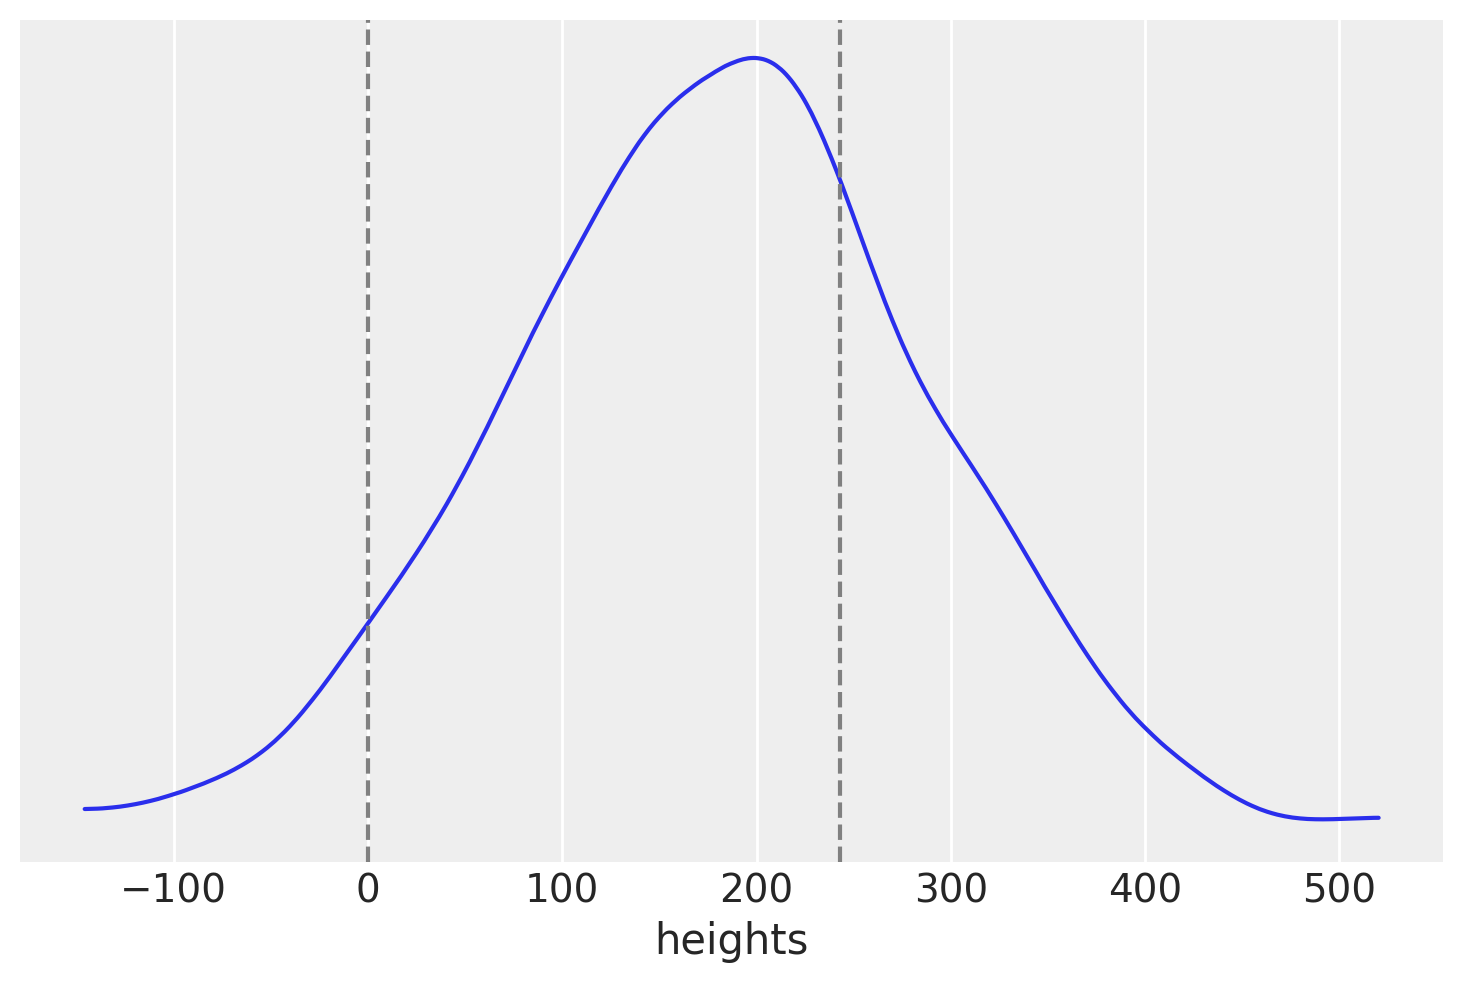

In [110]:
n_samples = 1000
new_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
new_prior = stats.norm.rvs(loc=new_mu, scale=sample_sigma)
az.plot_kde(new_prior)
plt.xlabel("heights")
plt.yticks([])
plt.axvline(0, color="grey", linestyle="--")
plt.axvline(243, color="grey", linestyle="--")

##### Figure 4.3. Putting it all together.

In [111]:
#################################################
# An additional plot replicating Fig 4.3 on p. 63
# Trying to make the same plot as above in plotly
#################################################


fig = make_subplots(rows=2, cols=2)


### Top left plot ###
fig.add_trace(
    go.Scatter(x=x_mu, y=stats.norm.pdf(x_mu, 178, 20), line_color="gold",),
    row=1, col=1,
)
fig.update_xaxes(title_text="Mu", row=1, col=1)
fig.update_yaxes(title_text="Density", row=1, col=1)

#### Finding the peak average height in the mu Chart ####
x_max = x_mu[stats.norm.pdf(x_mu, 178, 20).argmax()]
y_max = max(stats.norm.pdf(x_mu, 178, 20))
# Add an annotation above the peak of the line graph
fig.add_annotation(x=x_max, y=y_max, text="mu ~ dnorm(178, 20)")
### ###
#####################


### Top right plot ###
fig.add_trace(
    go.Scatter(x=x_sigma, y=stats.uniform.pdf(x_sigma, 0, 50), line_color="silver"),
    row=1, col=2,
)
fig.update_xaxes(title_text="Sigma", row=1, col=2)
# fig.update_yaxes(title_text="Density", row=1, col=2)

fig.add_annotation(
    x=25, y=y_max,
    text="sigma ~ dunif(0, 50)",
    row=1, col=2
)
######################


### Bottom left plot ###
kde = ff.create_distplot([prior_h], group_labels=["Prior"], colors=["#FF2400"], show_hist=False) #Used hex string for scarlet
fig.add_trace(
    kde.data[0],
    row=2, col=1
)

#### Finding the peak value in the KDE Chart ####
gauss = stats.gaussian_kde(prior_h) # Fit a KDE to the data
x = np.linspace(np.min(prior_h), np.max(prior_h), 100) # Evaluate the KDE at a range of x values
y = gauss.evaluate(x)
index_max = np.argmax(y) # Find the index of the maximum y value
x_peak = x[index_max] # Find the x and y coordinates of the peak of the KDE chart
y_peak = y[index_max]
#### ####

fig.add_annotation(
    x=x_peak, y=(y_peak + 0.0001),
    text="h ~ dnorm(mu, sigma)",
    row=2, col=1
)

fig.update_xaxes(title_text="Heights", row=2, col=1)
fig.update_yaxes(title_text="Density", row=2, col=1)

#########################


### Bottom right plot ###
#### Finding the peak value in the KDE Chart ####
new_gauss = stats.gaussian_kde(new_prior)
x2 = np.linspace(np.min(new_prior), np.max(new_prior), 100) # Evaluate the KDE at a range of x values
y2 = new_gauss.evaluate(x2)
index_max2 = np.argmax(y2) # Find the index of the maximum y value
x_peak2 = x2[index_max2] # Find the x and y coordinates of the peak of the KDE chart
y_peak2 = y2[index_max2]
#### ####

kde2 = ff.create_distplot([new_prior], group_labels=["New Prior"], colors=["#7F00FF"], show_hist=False)

fig.add_trace(
    kde2.data[0],
    row=2, col=2
)

fig.add_scatter(
    x=[0, 0],
    y=[0, 0.004],
    mode="lines",
    line={"color": "#E6E6FA", "width": 2, "dash": "dot"},
    showlegend=False,
    row=2, col=2
)

fig.add_scatter(
    x=[243, 243],
    y=[0, 0.004],
    mode="lines",
    line={"color": "#E6E6FA", "width": 2, "dash": "dot"},
    showlegend=False,
    row=2, col=2
)

fig.update_xaxes(title_text="Heights", row=2, col=2)

fig.add_annotation(
    x=x_peak2, y=y_peak2,
    text="h ~ dnorm(mu, sigma) <br> mu ~ dnorm(178, 100)",
    row=2, col=2
)
###########################


### Updating the general layout ###
fig.update_layout(
    template="plotly_dark",
    showlegend=False,
    title_text="Figure 4.3: Gaussian Model of Height",
    height=700, width=900
)

### 4.3.3. Grid approximation of the posterior distribution.

Since this is the first Gaussian model we've built, let's do a brute force calculation to map out the posterior distribution. In the future, this method isn't encouraged because it's computationally expensive and laborious. In future chapters, we can instead use quadratic approximation or Markov Chain Monte Carlo Approximations to estimate the posterior distribution.


#### Code 4.16

In [112]:
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

likelihood = [
    sum(stats.norm.logpdf(d2.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

post_prod_sum = (
    likelihood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)
post_prob = np.exp(post_prod_sum - max(post_prod_sum))

ChatGPT's explanation of the following code:

> This code calculates the posterior probability of the mean and standard deviation of a normal distribution, given a set of data points. The posterior probability is the probability of the mean and standard deviation of the normal distribution given the data, i.e., the probability of the mean and standard deviation after taking into account the data. <br><br>
   The first line of the code generates a meshgrid of possible values for the mean and standard deviation of the normal distribution, using the `mgrid` function. The meshgrid has shape `(100, 40)`, where each element is a tuple `(mean, std)`. The values of mean will range from 150 to 159.95 in steps of 0.05, and the values of std will range from 7 to 8.95 in steps of 0.05. For example, the first element of the first row of the generated array will be `(150, 7)`, while the second element of the first row will be `(150, 7.05)`, and so on. <br><br>
   The `reshape` function is then used to reshape the array into a 2D array with shape `(2, 4000)`, where the first column contains the means and the second column contains the standard deviations. The argument `-1` means that the size of the second dimension will be inferred from the size of the array and the desired shape. <br><br>
   Finally, the `T` attribute is used to transpose the array, so that it has shape `(4000, 2)` with 4000 rows and 2 columns. This is done so that each row of the array represents a pair of mean and standard deviation. <br><br>
   Next, the code calculates the `likelihood` values of the data within the `d2['height']` Series given each possible pair of mean and standard deviation in the meshgrid. The `likelihood` is the probability of the data given the mean and standard deviation of the normal distribution. It is calculated using the `norm.logpdf` function from the `scipy.stats` library, which calculates the logarithm of the probability density function (PDF) of the normal distribution. The  following equation expresses the `scipy.stats.norm.logpdf()` function:
   
$$\ln \left( \frac{1}{\sqrt{2 \pi \sigma^2}}^{-\frac{(x-\mu)^2}{2 \sigma^2}} \right) = log_{e}(\frac{1}{\sqrt{2 \pi \sigma^2}}^{-\frac{(x-\mu)^2}{2 \sigma^2}}) $$

  > Then, the code calculates the prior probabilities of the mean and standard deviation. The prior probability of a parameter is the probability of the parameter before taking into account the data. In this case, the prior probability of the mean is modeled as a normal distribution with mean `178` and standard deviation `20`, and the prior probability of the standard deviation is modeled as a uniform distribution between `0` and `50`. The prior probabilities are also calculated using the `norm.logpdf` and `uniform.logpdf` functions from `scipy.stats`. <br><br>
  Finally, the code calculates the posterior probability of each pair of mean and standard deviation in the meshgrid as the product of the likelihood and the prior probabilities. It then exponentiates the logarithm of the posterior probabilities and normalizes them so that they sum up to 1. This is done using the `exp` function and the `max` function. The resulting array `post_prob` has the same shape as the meshgrid and contains the posterior probabilities of each pair of mean and standard deviation.

In [113]:
################################################
### Understanding np.meshgrid() in Code 4.16 ###
################################################

# Here is an example of what a meshgrid looks like...
example_mesh = np.mgrid[150:160:0.5, 7:9:0.5]

print(f"Example meshgrid: \n {example_mesh} \n\n with a shape of {example_mesh.shape}.")
print(f"The shape of the real example is {np.mgrid[150:160:0.05, 7:9:0.05].shape} \n\n")

print(f"Now here is the shape of our reshaped mesh grid: {np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).shape}")
print(f"Along with the shape of the example mesh: {example_mesh.reshape(2, -1).shape}")

# The -1 argument in .reshape() combined all the values 150-160 (avg) and 7-9 (st. devs) into one big list
# so that we have a mesh with 2 columns of 8,000 values.
print(f" And what it actually looks like now: \n {example_mesh.reshape(2, -1)}")

Example meshgrid: 
 [[[150.  150.  150.  150. ]
  [150.5 150.5 150.5 150.5]
  [151.  151.  151.  151. ]
  [151.5 151.5 151.5 151.5]
  [152.  152.  152.  152. ]
  [152.5 152.5 152.5 152.5]
  [153.  153.  153.  153. ]
  [153.5 153.5 153.5 153.5]
  [154.  154.  154.  154. ]
  [154.5 154.5 154.5 154.5]
  [155.  155.  155.  155. ]
  [155.5 155.5 155.5 155.5]
  [156.  156.  156.  156. ]
  [156.5 156.5 156.5 156.5]
  [157.  157.  157.  157. ]
  [157.5 157.5 157.5 157.5]
  [158.  158.  158.  158. ]
  [158.5 158.5 158.5 158.5]
  [159.  159.  159.  159. ]
  [159.5 159.5 159.5 159.5]]

 [[  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5]
  [  7.    7.5   8.    8.5

In [114]:
########################################################################
### Understanding how we got the posterior distribution in Code 4.16 ###
########################################################################

grid_approx_post = (
    likelihood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)

print(f"The sum of each likelihood distribution we generated using the values in the mesh grid: \n \
{likelihood[:5]} \n",
      f" + the log distribution of means: {stats.norm.logpdf(post[:, 0], loc=178, scale=20)[:5]} \n",
      f" + the log distribution of standard deviations: {stats.uniform.logpdf(post[:, 1], loc=0, scale=50)[:5]} \n\n")

print(f"= the summed posterior distribution: \n {grid_approx_post[:5]}")

The sum of each likelihood distribution we generated using the values in the mesh grid: 
 [-1299.030295605718, -1297.428225106116, -1295.8949193620315, -1294.428216599498, -1293.0260332478672] 
  + the log distribution of means: [-4.89467081 -4.89467081 -4.89467081 -4.89467081 -4.89467081] 
  + the log distribution of standard deviations: [-3.91202301 -3.91202301 -3.91202301 -3.91202301 -3.91202301] 


= the summed posterior distribution: 
 [-1307.83698942 -1306.23491892 -1304.70161317 -1303.23491041
 -1301.83272706]


In [115]:
grid_post_prob = np.exp(grid_approx_post - max(grid_approx_post))

print(f"The largest value in our summed posterior distribution from which all the other values will be subtracted from before being exponentiated: {max(grid_approx_post)} \n")
print(f"The exponentiated posterior distribution (i.e. our z-values): \n {grid_post_prob[:5]}")

The largest value in our summed posterior distribution from which all the other values will be subtracted from before being exponentiated: -1227.9183049610137 

The exponentiated posterior distribution (i.e. our z-values): 
 [1.95774597e-35 9.71687726e-35 4.50228456e-34 1.95170357e-33
 7.93184738e-33]


#### Code 4.17

Now that we've generated our posterior distribution, we can inspect them using tools like a contour plot.

Note that what the `scipy.interpolate.griddata()` function does, according to ChatGPT, is it's used to interpolate data on a grid. It takes in three arrays:
1. the coordinates of the data `points` such as the one provided by the mesh grid,
2. the data points themselves (the `values` parameter), which in this case are the exponentiated posterior probabilities),
3. and the coordinates of the points at which the interpolated data is desired (the `xi` parameter), which are the values between the min and the max of the mesh grid.

It then returns the interpolated data at those desired points. The interpolation method used can be specified as a parameter, with options such as "linear", "cubic", and "nearest" available in the `method="linear"` parameter. It is helpful for tasks such as filling in missing data or creating a smooth representation of discrete data points.

And for further context, **interpolation** is the process of estimating a function's value at a point between two known values. It is often used to estimate values in a dataset that contains gaps or missing data. In the case of `scipy.interpolate.griddata()`, it is used to estimate values at specific points within a grid based on the known data points and their coordinates. This process calculates the unknown data points based on the known ones, like what we do with machine learning. In this case, we're trying to fill all the missing values based on x and y coordinates given from the mesh grid earlier.

Also, `plt.contour()` is a function in the Matplotlib library used to create contour plots. A contour plot is a graphical representation of a 3-dimensional surface, where the surface levels are represented by [contour lines](https://en.wikipedia.org/wiki/Contour_line). The `plt.contour()` function takes in 2-dimensional arrays of x and y coordinates and corresponding z values and plots the contour lines of the surface defined by those coordinates and values. It can be used to visualize data such as topographic maps or to display the level sets of a function of two variables. It is often used in scientific research, physics and engineering to visualize the behaviour of physical systems.

Text(0.5, 1.0, 'The approximate distr values of avg height and std devs')

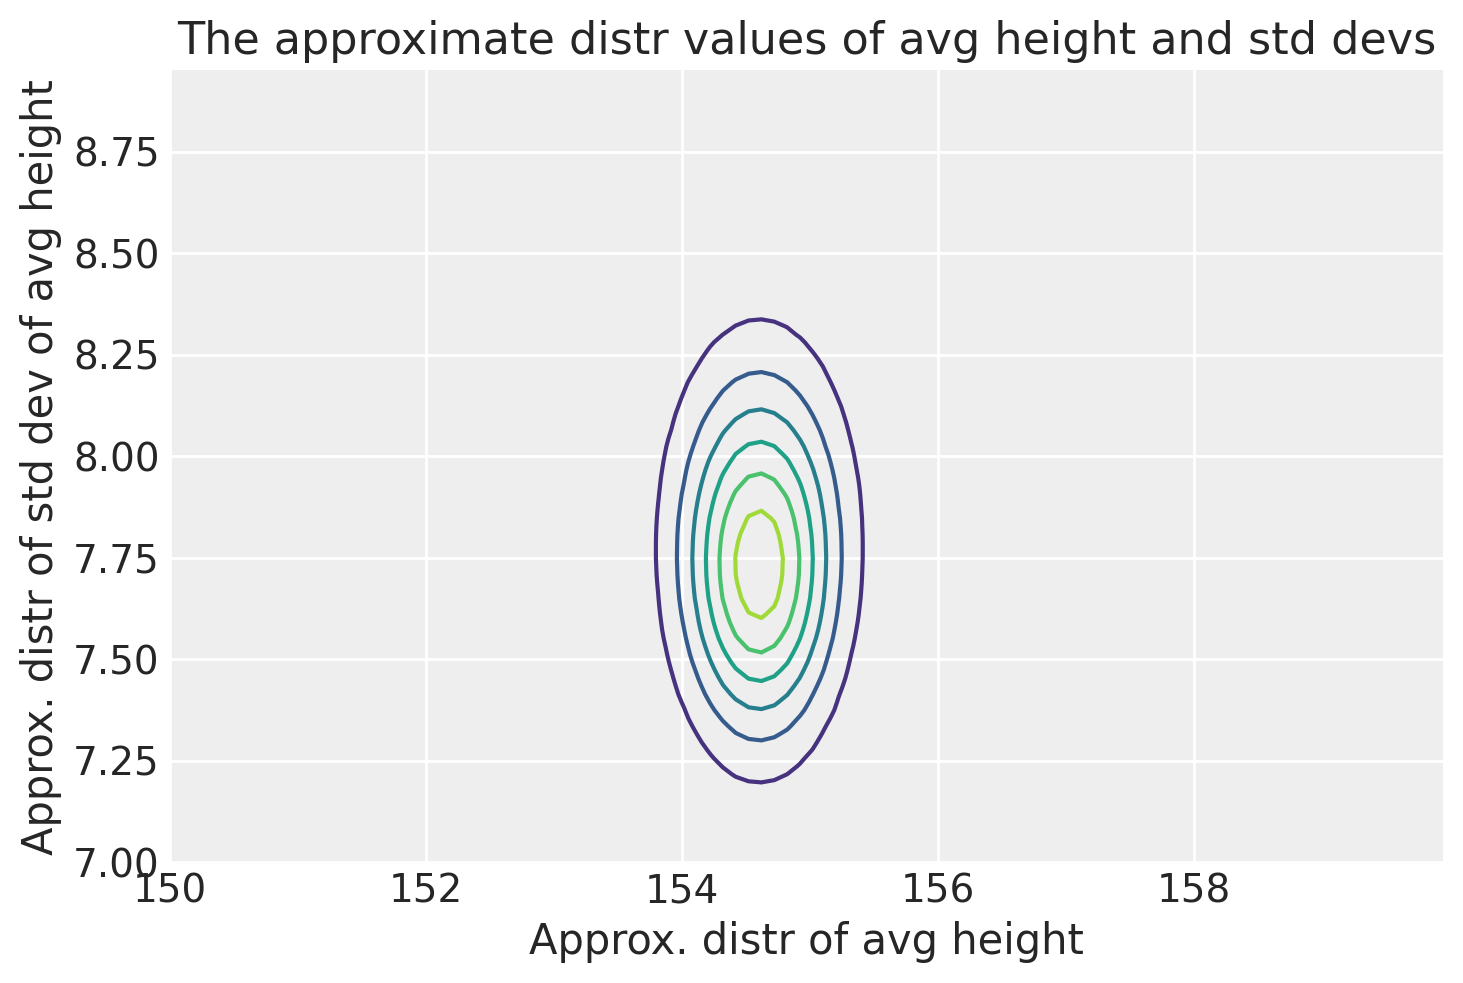

In [116]:
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata(points=(post[:, 0], post[:, 1]), values=post_prob, xi=(xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi)
plt.xlabel("Approx. distr of avg height")
plt.ylabel("Approx. distr of std dev of avg height")
plt.title("The approximate distr values of avg height and std devs")

In [117]:
interpolated_post = griddata(points=(post[:, 0], post[:, 1]), values=post_prob, xi=(xi[None, :], yi[:, None]))

print(f"The interpolated grid data of the posterior dist (zi) has a shape of {interpolated_post.shape} \n")
print(f"And the below is what the grid data (zi) looks like: \n {interpolated_post}")

The interpolated grid data of the posterior dist (zi) has a shape of (100, 100) 

And the below is what the grid data (zi) looks like: 
 [[1.95774597e-35 5.37793865e-34 1.36827963e-32 ... 1.34029787e-43
  3.05783055e-45 6.44733778e-47]
 [5.01437345e-35 1.29922902e-33 3.46876236e-32 ... 4.67135417e-43
  1.06948800e-44 2.23741635e-46]
 [8.07100093e-35 2.06066418e-33 5.23506941e-32 ... 7.31151261e-43
  1.74145656e-44 3.83009892e-46]
 ...
 [5.22778843e-24 4.02013452e-23 2.95081272e-22 ... 5.81573970e-29
  5.71109412e-30 5.35779983e-31]
 [5.29219577e-24 4.03337412e-23 2.93563183e-22 ... 6.19638489e-29
  6.15477341e-30 5.84471602e-31]
 [5.35660311e-24 4.04599507e-23 2.92045094e-22 ... 6.61332603e-29
  6.62065901e-30 6.33163222e-31]]


#### Code 4.18

We can also use a heatmap to inspect the posterior distribution.

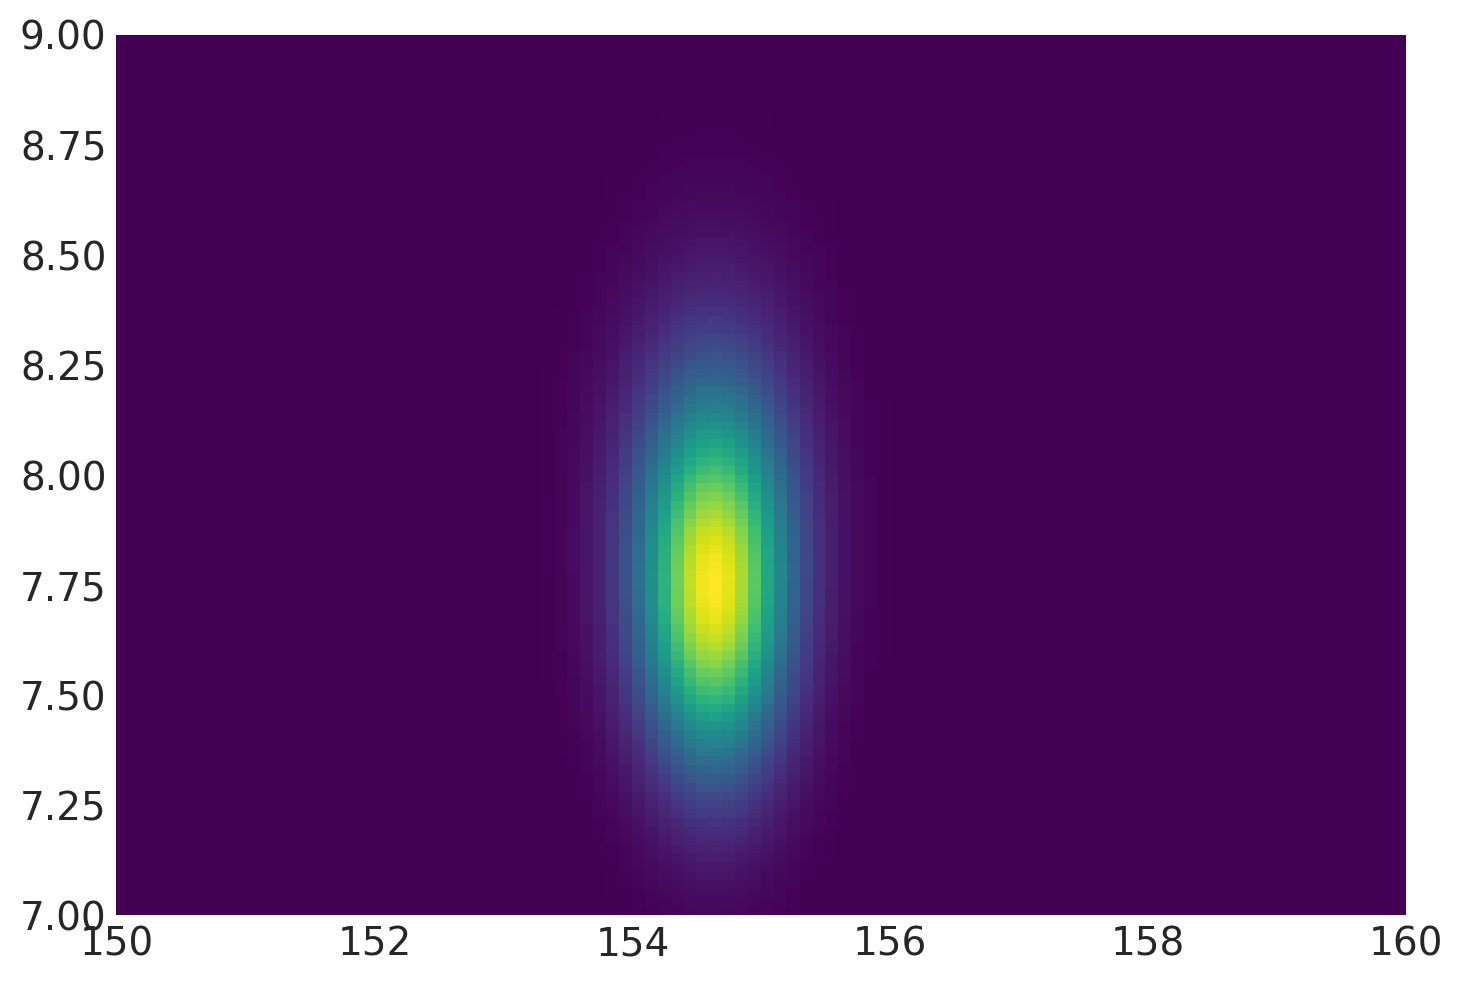

In [118]:
_, ax = plt.subplots()
ax.imshow(zi, origin="lower", extent=[150.0, 160.0, 7.0, 9.0], aspect="auto")
ax.grid(False)

### 4.3.4. Sampling from the posterior [GRID APPROX RECAP].

To recap how we produced a grid approximate of the posterior distribution:

1. We generated a mesh grid (`post`) of mean values and standard deviations,
2. Then we generated likelihood values/probabilities of the data (`likelihood`) using those combinations of means, standard deviations, and each of the values in the `d2['Heights']` series,
3. As well as added each individual likelihood value with each value from the distribution of means and standard deviations in `post_prob_sum`,
4. And finally, we exponentiated the difference between each of the 8000 values in the `post_prob_sum` and the max value, which is `-1227.918...`, which returned our <u>grid-approximated posterior distribution</u>  represented by the `post_prob` object.
  - **Note**: Exponentiated (`np.exp()`) means to find the value of Euler's number ($e = 2.7182...)$ raised to the power of $x$ (again, the value that we're solving for), which in this case is each value in the `post_prob_sum`, which we can represent as $y$: $e^x = y$

Now that we've generated our posterior distribution, let's study it in more detail by sampling from it just like in Chapter 3. However, the difference now with our sampling is that we have <u>two parameters</u> to sample from.

#### Code 4.19


In the first line of code 4.19, we'll want to sample the *row numbers* (i.e. `sample_rows`) of the combinations of means and standard deviations stored in our `post` mesh grid that are proportionate to the values in our exponentiated `post_prob` distribution. From there, we'll generate a new array of `sample_mu` and `sample_sigma` from the sampled row numbers in the previous line of code.


In [119]:
sample_rows = rng.choice(
    np.arange(len(post)), size=10000, replace=True, p=(post_prob / post_prob.sum())
) # Note that `rng.choice()` is pretty much the same as `np.random.choice()`
sample_mu = post[:, 0][sample_rows]
sample_sigma = post[:, 1][sample_rows]

In [120]:
print(f"The probabilities generated for our sample rows by dividing each value in `post_prob` against the sum of the array: \n {post_prob / post_prob.sum()} \n")
print(f"And the row numbers generated from the posterior probabilities from which we'll sample mean and stdev values: \n {sample_rows}")

The probabilities generated for our sample rows by dividing each value in `post_prob` against the sum of the array: 
 [6.44634399e-38 3.19951282e-37 1.48248422e-36 ... 1.31552677e-33
 1.67785210e-33 2.08484042e-33] 

And the row numbers generated from the posterior probabilities from which we'll sample mean and stdev values: 
 [3973 3973 3775 ... 3574 3811 3781]


#### Code 4.20

And now, we can plot each of those 10,000 sampled values in the scatter plot in Figure 4.4. Notice how there tends to be a higher density of data in the center of the scatter plots. These data points represent the most plausible combination of $\mu$ and $\sigma$, but there are many more ways for these parameter values to produce the data, given the model.

Text(0.5, 1.0, 'Figure 4.4. Samples from the posterior distribution of height data')

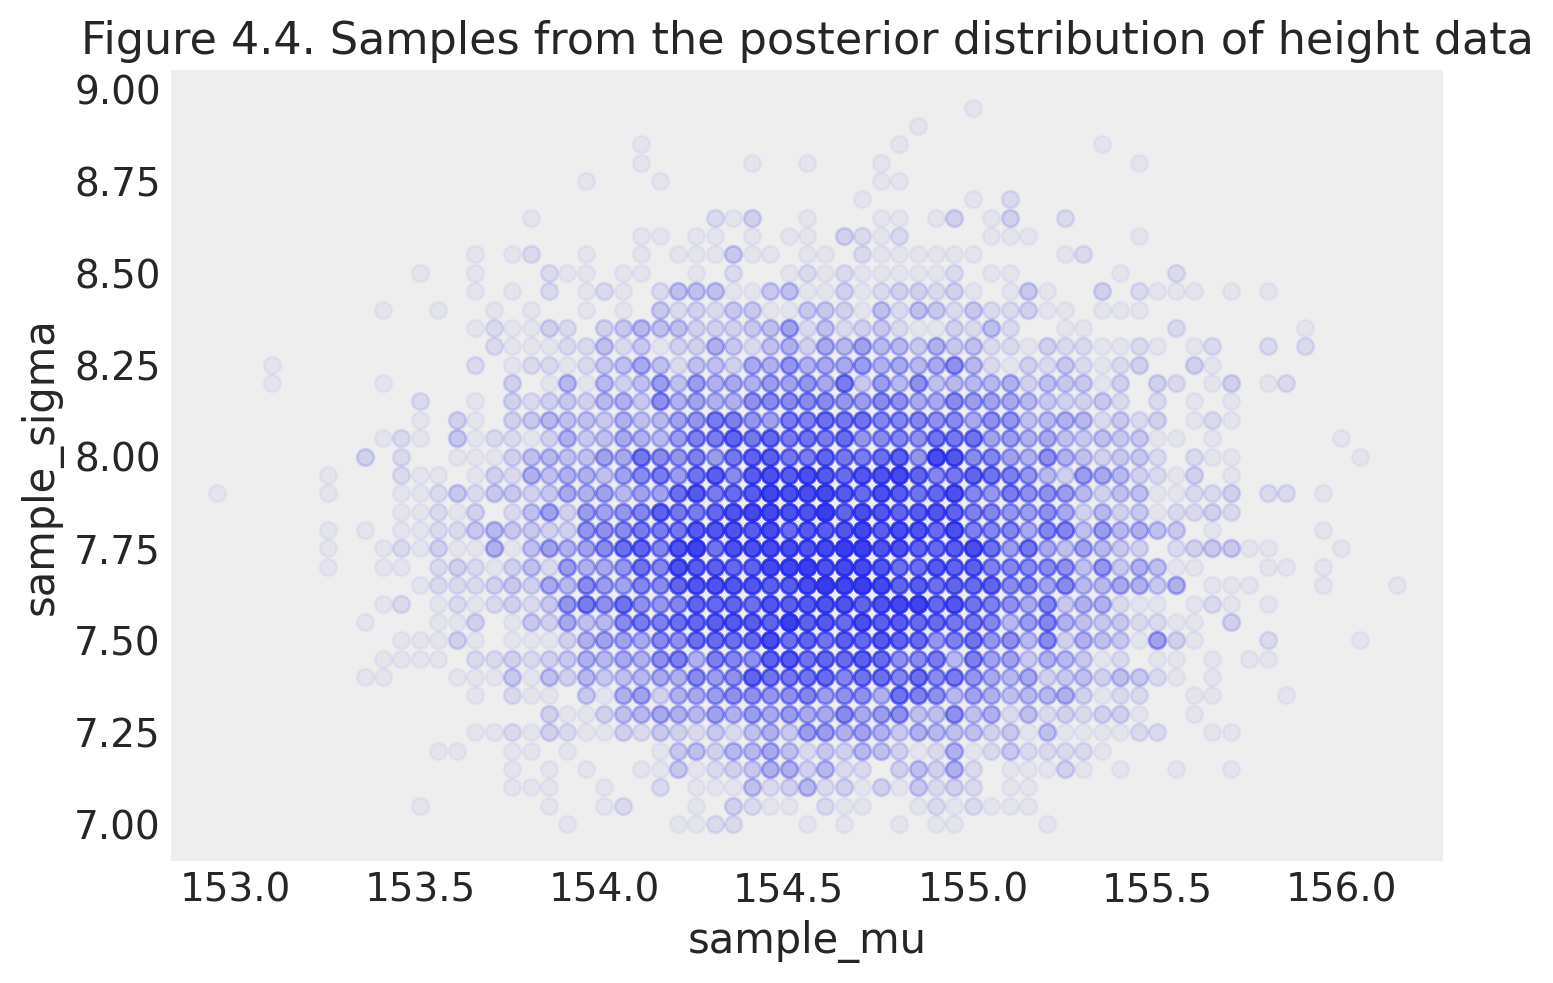

In [121]:
plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma")
plt.title("Figure 4.4. Samples from the posterior distribution of height data")

#### Code 4.21

By generating a kernel density chart, we can also characterize the shapes of the **marginal posterior densities** of $\mu$ and $\sigma$. In this context, we can use the term *marginal* to mean the "average over other parameters." Notice how these densities look very similar to normal distribution which tends to happen as we increase the sample size. However, our standard deviation $\sigma$ distribution tends to have a longer right-tail which also tends to occur for parameters-related standard deviations.

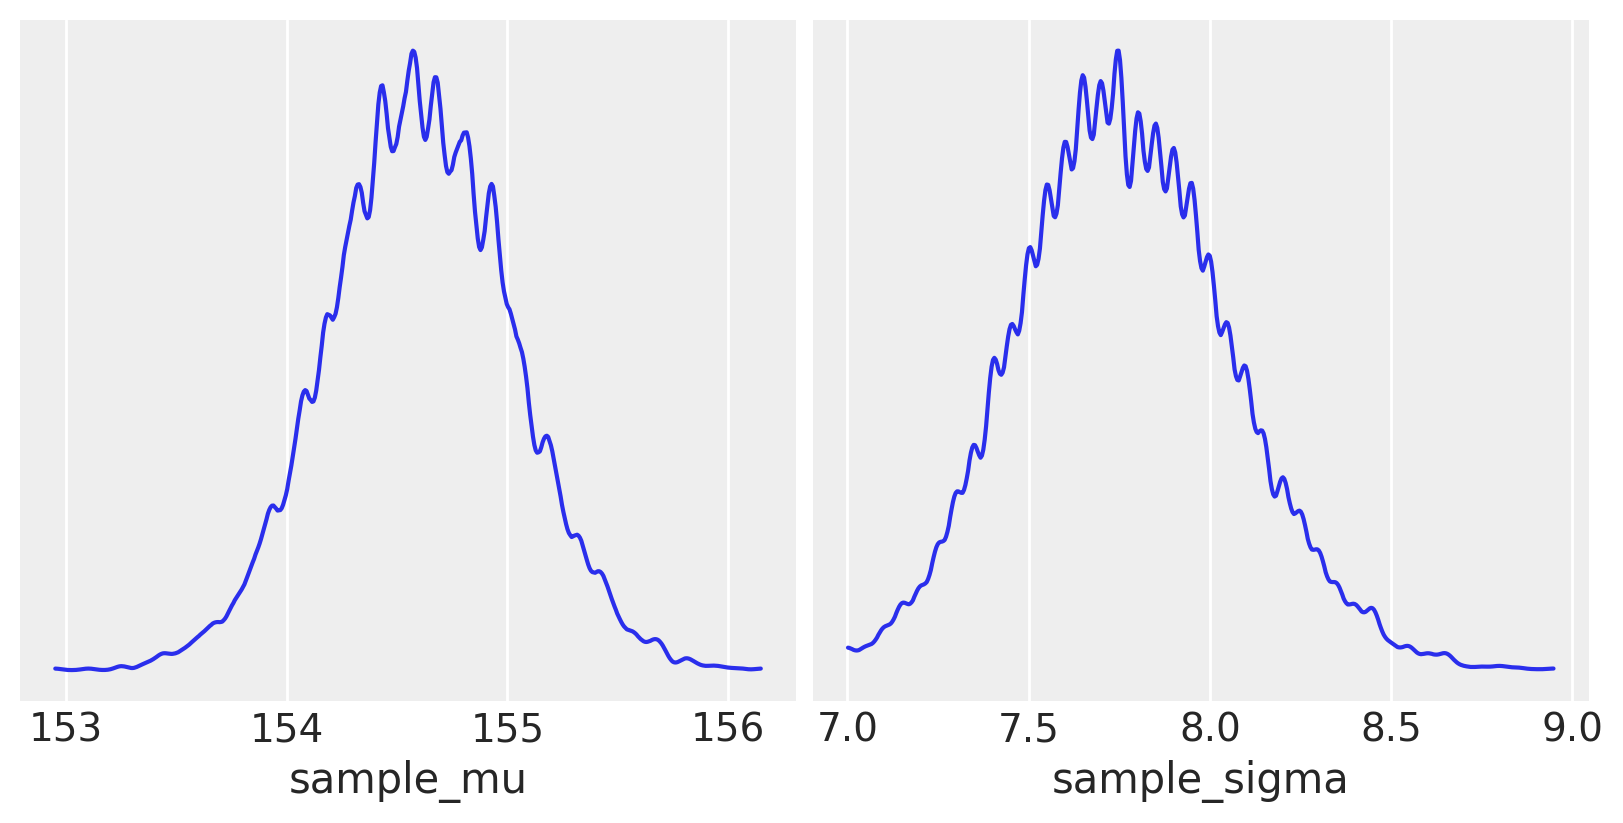

In [122]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel("sample_mu")
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel("sample_sigma")
ax[1].set_yticks([]);

#### Code 4.22

We can also summarize the width of these densities by using `az.hdi()` (highest density intervals) to calculate the intervals with the highest density for both parameters.

In [123]:
az.hdi(sample_mu), az.hdi(sample_sigma)

(array([153.9, 155.2]), array([7.3, 8.2]))

#### **Overthinking: Sample size and the normality of $\sigma$'s posterior.**

Before moving on to quadratic approximation, it's worth reviewing the process of grid approximating the posterior distribution of height data with only a fraction of it instead. The reason we'd want to do this is to demonstrate that *a posterior may not always be so Gaussian in shape*, as we'll see with distributions of standard deviations $\sigma$.

Gaussian likelihoods and priors based on the mean $\mu$ usually stay Gaussian, regardless of the sample size. However, standard deviations $\sigma$ seem to cause problems, so if you care about it (and often people do not), beware of abusing the quadratic approximation.

One of the reasons for standard deviations having a long right tail is that the variances must be a positive number. As a result, there tends to be more uncertainty about how significant the variance/standard deviation is rather than how small it is.

For example, suppose the variance is estimated to be near zero. In that case, you'll probably think that if there were to be an error with your calculation, the likely outcome would be that the variance is much larger than what's on paper.

Let's start with sampling 20 heights in Code 4.23 to explore this issue.

#### Code 4.23

In [124]:
d3 = rng.choice(d2.height, 20)

#### Code 4.24

Next, we'll repeat the procedure from code cells 4.16 and 4.19 with our `d3` array of 20 sampled heights.

In [125]:
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2, -1).T

likelihood2 = [
    sum(stats.norm.logpdf(d3, loc=post2[:, 0][i], scale=post2[:, 1][i])) for i in range(len(post2))
]

post_prod2 = (
    likelihood2
    + stats.norm.logpdf(post2[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post2[:, 1], loc=0, scale=50)
)

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = rng.choice(
    np.arange(len(post2)), size=10000, replace=True, p=(post_prob2 / post_prob2.sum())
)
sample_mu2 = post2[:, 0][sample_rows2]
sample_sigma2 = post2[:, 1][sample_rows2]

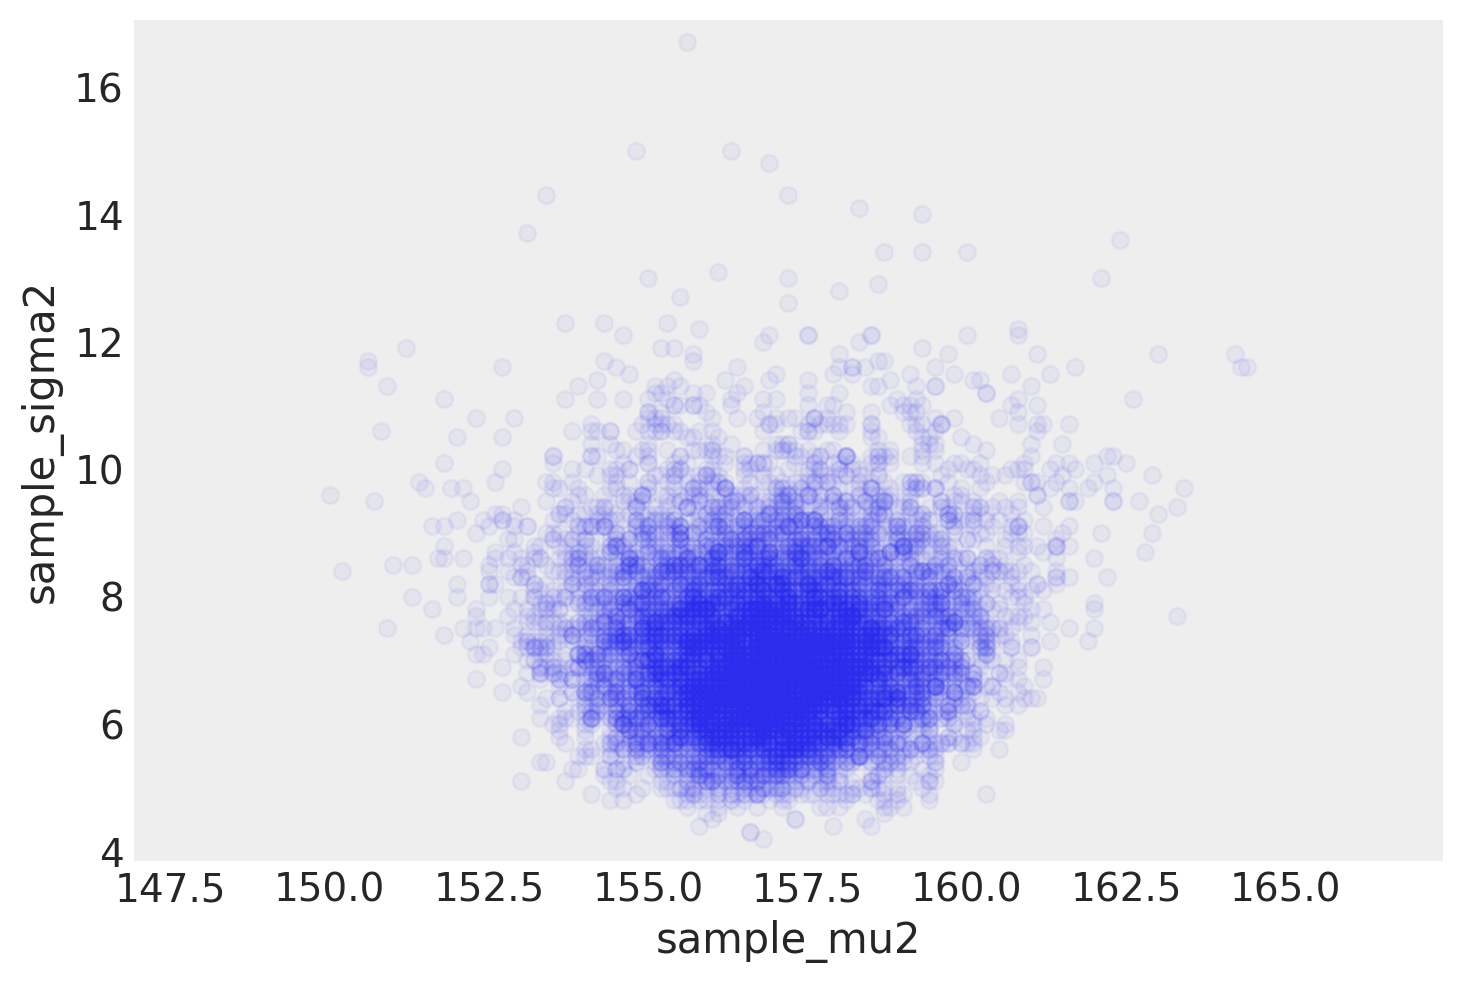

In [126]:
plt.plot(sample_mu2, sample_sigma2, "o", alpha=0.05)
plt.axis("equal")
plt.xlabel("sample_mu2")
plt.ylabel("sample_sigma2")
plt.grid(False);

#### Code 4.25

After generating another density plot with the smaller sample, we'll notice a distinctly longer right tail which further illustrates the general properties of standard deviations $\sigma$.

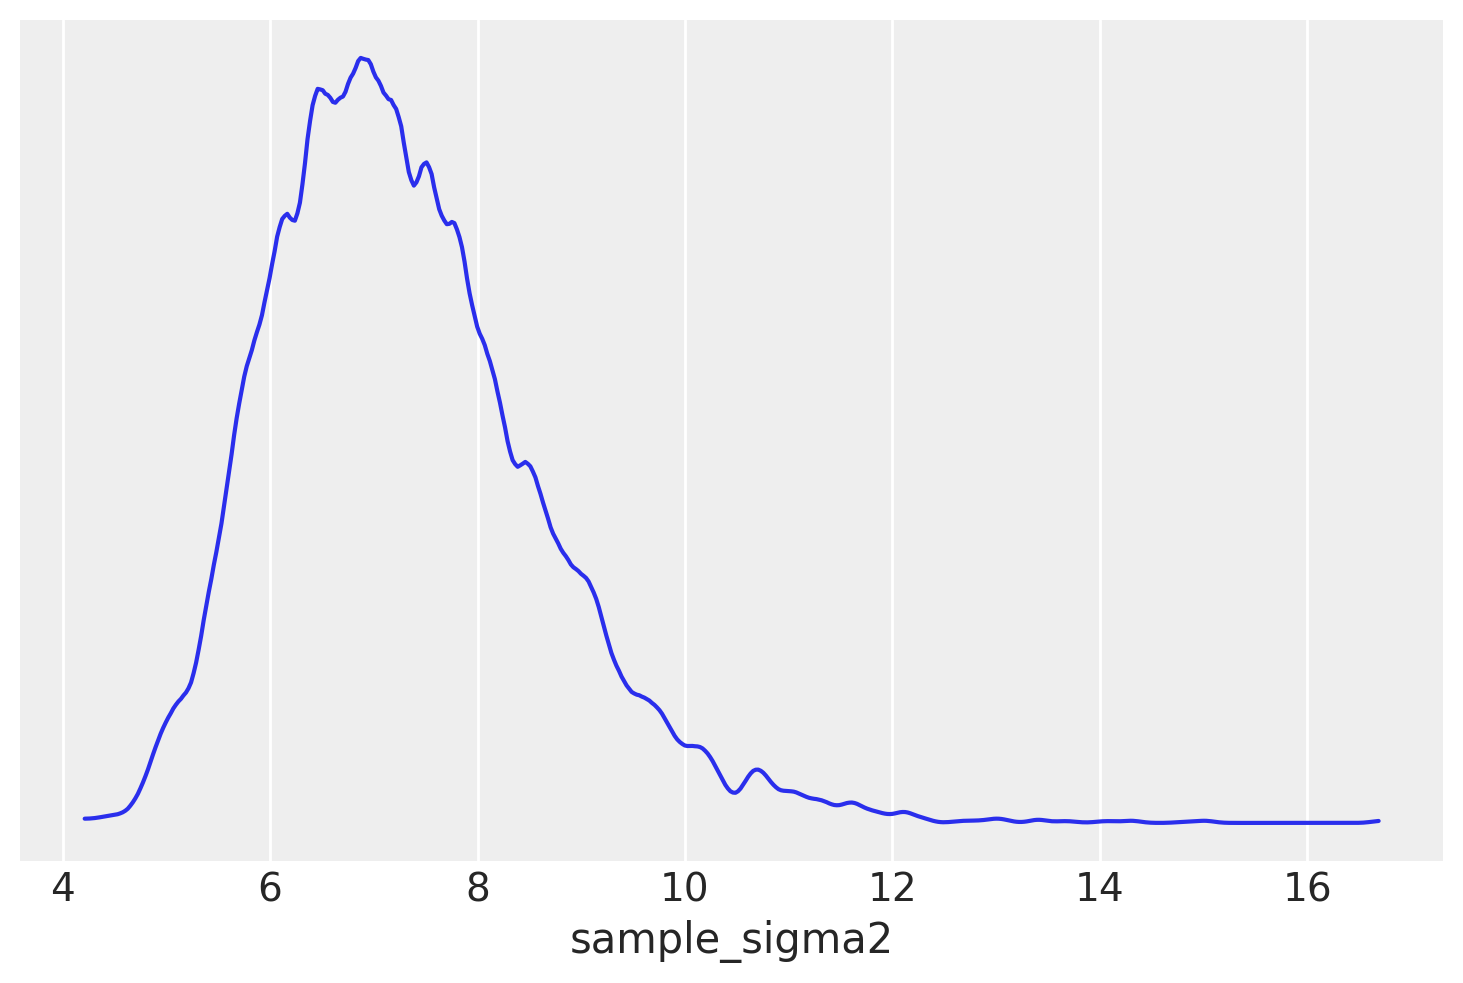

In [127]:
az.plot_kde(sample_sigma2)
plt.xlabel("sample_sigma2")
plt.yticks([]);

### **4.3.5. Finding the distribution of the posterior using quadratic approximation.**

Let's now turn our attention from grid approximation to **[quadratic approximation](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/quadratic-approximations/a/quadratic-approximation)**, one of the greatest engines of applied statistics which allows us to quickly make inferences about the shape of a distribution. In Chapter 2, we introduced the **maximum a posteriori (MAP)** estimate, which is essentially the peak of the posterior distribution and will allow us to get a helpful image of its shape using quadratic approximation.

Let's first start by re-creating our heights dataset of the !Kung San population.

#### Code 4.26

We are repeating code 4.7, 4.8 and 4.10

In [128]:
# d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)

# ALTERNATE CODE IF YOU HAVEN'T DOWNLOADED THE DATA
# path = "https://raw.githubusercontent.com/pymc-devs/pymc-resources/main/Rethinking_2/Data/Howell1.csv"
# d = pd.read_csv(path, sep=";", header=0)
d18 = d[d.age >= 18]

#### Code 4.27

Then with our `pymc.Model()`, we can use the model definitions we specify and introduced in Section 4.2; we can define the posterior probability with the combination of these parameter values. From there, the model finds the peak of the distributions (again, the MAP) and then estimates the quadratic curvature of the MAP to approximate the posterior distribution.

Another reminder of our model's definitions:

$h_{i} \sim 𝓝(\mu, \sigma)$

$\mu \sim Normal(178, 20)$

$ \sigma \sim Uniform(0, 50)$

In [129]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20) # Our first prior - Distribution of means given an optimal estimate of the mean and stdev using our prior knowledge
    sigma = pm.Uniform("sigma", lower=0, upper=50) # Our second prior - A uniform distribution of possible standard deviations
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d18["height"])  # Generates a normal prior distribution given the mean, standard deviation, and the observed data


map_estimate = pm.find_MAP(model=m4_1)
print(map_estimate)


{'mu': array(154.60702358), 'sigma_interval__': array(-1.69876478), 'sigma': array(7.73133303)}


Now let's do a quick recap and get into further detail about quadratic approximation based on what we learned in Chapter 2. **Quadratic approximation** assumes that the posterior distribution it's approximating is Gaussian in shape, which it then aims to recreate by:

1. Finding the **MAP** (i.e. the peak of the distribution which is also effectively its **mean ($\mu$)**):

 - The default optimization algorithm for the `pymc.find_MAP()` function (maximum a priori) in PyMC is called the **[Broyden-Fletcher-Goldfarb-Shanno (BFGS)](https://machinelearningmastery.com/bfgs-optimization-in-python/)**. The documentation in PyMC lists this algorithm as "L-BFGS-B," which stands for **Limited-memory BFGS with Bounds**.
 - The **BFGS algorithm** is a local search, second-order optimization algorithm that belongs to a class of algorithms that *approximate the second derivative (which we can also call the **Hessian**)* of an objective function intended for *concave optimization problems* with a *single optima*. Whew! That was a lot. Ok, let's break down each of these concepts one-by-one to understand what the BFGS Algorithm is and how it finds the peak of a distribution:

<ol>
  <ol type="a">
    <li> <b>Second-Order Optimization Algorithms.</b> </li>
      <ol type="i">
        <li>From prior beginner <a href="https://docs.google.com/document/d/1rqeMAqJxUsN_Ovd7PR2JdK7JM0mIxe0BH9yeGm-NJ0g/edit?usp=sharing">Calculus</a> classes you may have taken, you may recall that <b>optimization</b> involves finding the parameters for a set of input values which optimize an objective function. </li>
        <li> You may also recall that the <b>first-order derivative</b> of a function equates to its rate of change or curvature at a specific point. In this case, an optimization algorithm, such as <b>gradient descent</b>, can help you approximate the lowest (or the highest) point in a curve, called the <i>minima</i> (or the <i>maxima</i>?). </li>
        <li> Well, a <b>second-order derivative</b> is a derivative of a derivative, or the rate of change for the rate of change, if you will. They can help the first-order derivative locate the optimum point, as well as the direction, of the objective function by providing it with more information. They can also estimate how far to move in a particular direction, which we can also call the <b>step size</b>, and is pretty much the same as making a <i>quadratic approximation</i> of the objective function. (<a href="https://algorithmsbook.com/optimization/files/optimization.pdf">Kochenderfer & Wheeler, 2019, p. 87</a>) </li>
        <li> When an objective function has more than 1 input variable, these input variables together may be thought of as a <b>vector</b> (like a column or a series in a dataframe) where each individual element is considered a <b>partial derivative</b>. Vectors are used to represent mathematical objects such as positions, velocities, and forces in physics, and they can be added, subtracted, and scaled using linear algebra operations. A <i>vector</i> of a <i>partial derivative</i> taken from the input variables in an objective function is referred to as a <b>gradient</b>. <p> At first glance, vectors and gradients may seem very similar, but they have a few key differences. For one, a <b>gradient</b> is both a vector that <i>point us towards the direction</i> of the greatest increase of a function AND tells us the rate of change in that direction via its <i>magnitude</i>. The gradient is also often termed the "slope" or "ascent direction" of a function. <p> For example, let's say we have a scalar function <code>f(x,y)</code> that describes the height of a mountain at point <code>(x,y)</code>. A vector could represent a hiker's <i>position</i> on the mountain, where the hiker can move around by adding or subtracting vectors. The gradient of the function at a point <code>(x,y)</code> on the mountain can be thought of as a <i>vector pointing in the direction of the steepest ascent</i> from that point. So, in other words, the gradient tells us the <i>direction</i> in which the hiker should move to climb the mountain as fast as possible, and its magnitude tells us the <i>rate</i> at which the height is increasing in that direction.</li>
        <li> And if we extend this idea of taking the second-order derivative (in other words, the derivative of the derivative) of the input variables of an objective function, we get a square and symmetric <b><a href="https://en.wikipedia.org/wiki/Hessian_matrix"> Hessian Matrix</a></b> which captures information about the local curvature of the function. (<a href="https://algorithmsbook.com/optimization/files/optimization.pdf">Kochenderfer & Wheeler, 2019, p. 87</a>) </li> </ol>

*An example of mathematically expressing a **Hessian Matrix**:*

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQdUtxWSWNslSasi5H5cIXk51ti6ZvTkGto1TldTCSgReDoEag2UqbrGZ7Hto976DBnmvI&usqp=CAU" width=275 height=200> <p><p><p>
    <li> <b>BFGS Optimization Algorithms.</b> </li>
      <ol type="i">
        <li> The BFGS Optimization Algorithm belongs to a class of algorithms known as <b>Quasi-Newton Methods</b>. One characteristic of Newton's method is that it requires us to <i>approximate the <a href="https://www.purplemath.com/modules/invrsfcn3.htm">inverse</a> of a Hessian matrix using the gradient</i>.</li>
        <li> <i>And by using the Hessian which provides us with information to determine both the direction and the step size to move towards to minimize (or maximize) the objective function, we're able to change the input parameters and arrive at the peak (maximum a priori).</i> </li>
        <li> <b>Limited Memory BFGS (L-BFGS)</b> is an extension of BFGS that addresses the cost of having a large number of parameters by not requiring the entire approximation of the Hessian stored. Instead, it assumes a simplification of the inverse Hessian from the previous iteration of the algorithm used in approximation.</li>
      </ol>
  </ol>
</ol>


2. Estimating its resulting curvature by fitting the data with a quadratic function (i.e. a parabola):

 - Now that we have a theoretical understanding of what's going on behind the algorithm, let's use a little math to bring these theories into practice.
 - The general formula for **[quadratic approximation](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/quadratic-approximations/a/quadratic-approximation)** for any scalar-valued function, which is a function that takes in multiple parameters (such as columns in a dataframe) and returns a single value, is the following:

 $$ Q_{f} = f(x_{0}) + \nabla f(x_{0}) \cdot (x - x_{0}) + \frac{1}{2}(x - x_{0})^T H_{f}(x_{0})(x - x_{0}) $$

   Where:

   - $f$ is a [scalar-valued function](https://www.sqlservertutorial.net/sql-server-user-defined-functions/sql-server-scalar-functions/). $f(x_0)$ is the value of the function `f` at a particular point $x_0$. The scalar-valued function $f$ used for `f(mu, sigma)` is the following:

  $$f(\mu, \sigma) = - \left(\sum_{i=1}^{n} \log(\sigma) + \frac{1}{2} \log(2 \pi) + \frac{1}{2} \frac{(d_{i} - \mu)^2}{\sigma^2}\right)$$

   - $\nabla f(x_{0})$ is the [gradient](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/partial-derivative-and-gradient-articles/a/the-gradient) of $f$ evaluated at $x_{0}$ which would typically be our MAP value. Again, the gradient is a vector that gives the function's rate of change in each direction. The gradient of the function ($\nabla f(x_{0})$) used for `grad_f(mu, sigma)` is the following:

  $$\begin{split}
  \nabla f(\mu, \sigma) &= \begin{bmatrix}
  \frac{\partial f(\mu, \sigma)}{\partial \mu} \\
  \frac{\partial f(\mu, \sigma)}{\partial \sigma}
  \end{bmatrix} \\
  \nabla f(\mu, \sigma) &= \begin{bmatrix}
  -\sum\limits_{i=1}^{N} \frac{d_i - \mu}{\sigma^2} \\
  -\left(\frac{1}{\sigma} - \sum\limits_{i=1}^{N} \frac{(d_i - \mu)^2}{\sigma^3}\right)
  \end{bmatrix}
  \end{split}$$

   - $H_{f}(x_{0})$ is the [Hessian Matrix](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/quadratic-approximations/a/approximating-multivariable-functions/a/the-hessian/) of the $f$ function evaluated at $x_{0}$. The Hessian matrix is a square matrix that represents the second derivatives of a function and describes the curvature of the function at a point.
    - The term $(x - x_{0})^T H_{f}(x_{0})(x - x_{0})$ is the second-order Taylor expansion of the function `f`. The function for the Hessian matrix of the posterior distribution $H_f(x_0)$ at the MAP point is `hessian_f(mu, sigma)` which consisted of the following equation:

  $$\begin{split}
  \mathcal{H}(\mu, \sigma) &= \begin{bmatrix}
  \frac{N}{\sigma^2} & \frac{\sum\limits_{i=1}^{N}(\mu-d_i)}{\sigma^3} \\
  \frac{\sum\limits_{i=1}^{N}(\mu-d_i)}{\sigma^3} & \left(\frac{1}{\sigma} - \sum\limits_{i=1}^{N} \frac{3(d_i - \mu)^2}{\sigma^4}\right)
  \end{bmatrix} \\
  \end{split}$$

      - $N$ is the number of samples
      - $d_i$ is the $i$-th sample of the height data.

In [130]:
x_0 = np.array([map_estimate["mu"], map_estimate["sigma"]])  # The MAP estimate of the model's parameters
n = d18["height"].shape[0]

# Define the scalar-valued function, which in this case would be the log-posterior distribution
def f(mu, sigma, data):
    return -1 * (np.log(sigma) + (0.5 * np.log(2 * np.pi)) + (0.5 * ((data - mu)** 2)) / sigma** 2).sum()

# Define the gradient of the function
def grad_f(mu, sigma, data):
    return np.array([
        -1 * ((data - mu) / sigma ** 2).sum(),
        -1 * (1 / sigma - ((data - mu) ** 2) / sigma ** 3).sum()
    ])

# Define the Hessian matrix of the function
def hessian_f(mu, sigma, data):
    return np.array([
        [
            (n / sigma**2),
            (mu - data).sum() / sigma**3
        ],
        [
            (mu - data).sum() / sigma ** 3,
            (1 / sigma - 3 * (data - mu) ** 2 / sigma ** 4).sum()
        ]
    ])

mu_map = x_0[0]
sigma_map = x_0[1]

x_minus_x_0 = np.array([mu_map, sigma_map]) - x_0
f_0 = f(mu_map, sigma_map, d18["height"])
print(f"The value of the scalar-valued function of the log-posterior distribution is {f_0} \n")

grad_f_0 = grad_f(mu_map, sigma_map, d18["height"])
print(f"The value of the function's gradient at the mean and the standard deviation is {grad_f_0} \n")

hessian_f_0 = hessian_f(mu_map, sigma_map, d18["height"])
print(f"The values of the Hessian Matrix of our function is the following: \n {hessian_f_0} \n")

Q_f = f_0 + np.dot(grad_f_0, x_minus_x_0) + 0.5 * np.dot(np.dot(x_minus_x_0, hessian_f_0), x_minus_x_0)
print(f"The Quadratic Approximation of the Posterior Distribution at the MAP value is {Q_f}")

The value of the scalar-valued function of the log-posterior distribution is -1219.4053815938414 

The value of the function's gradient at the mean and the standard deviation is [5.84824377e-02 4.43457902e-07] 

The values of the Hessian Matrix of our function is the following: 
 [[5.88889623e+00 7.56434078e-03]
 [7.56434078e-03 2.78623291e+01]] 

The Quadratic Approximation of the Posterior Distribution at the MAP value is -1219.4053815938414


And for some extra reading, here is some context with how quadratic approximation would work with a scalar-valued function of $f(x,y) = x^2 - y^2$ with a MAP value at $(0, 0)$.

(2, 40, 40)
(2, 40, 40) (1600, 2)


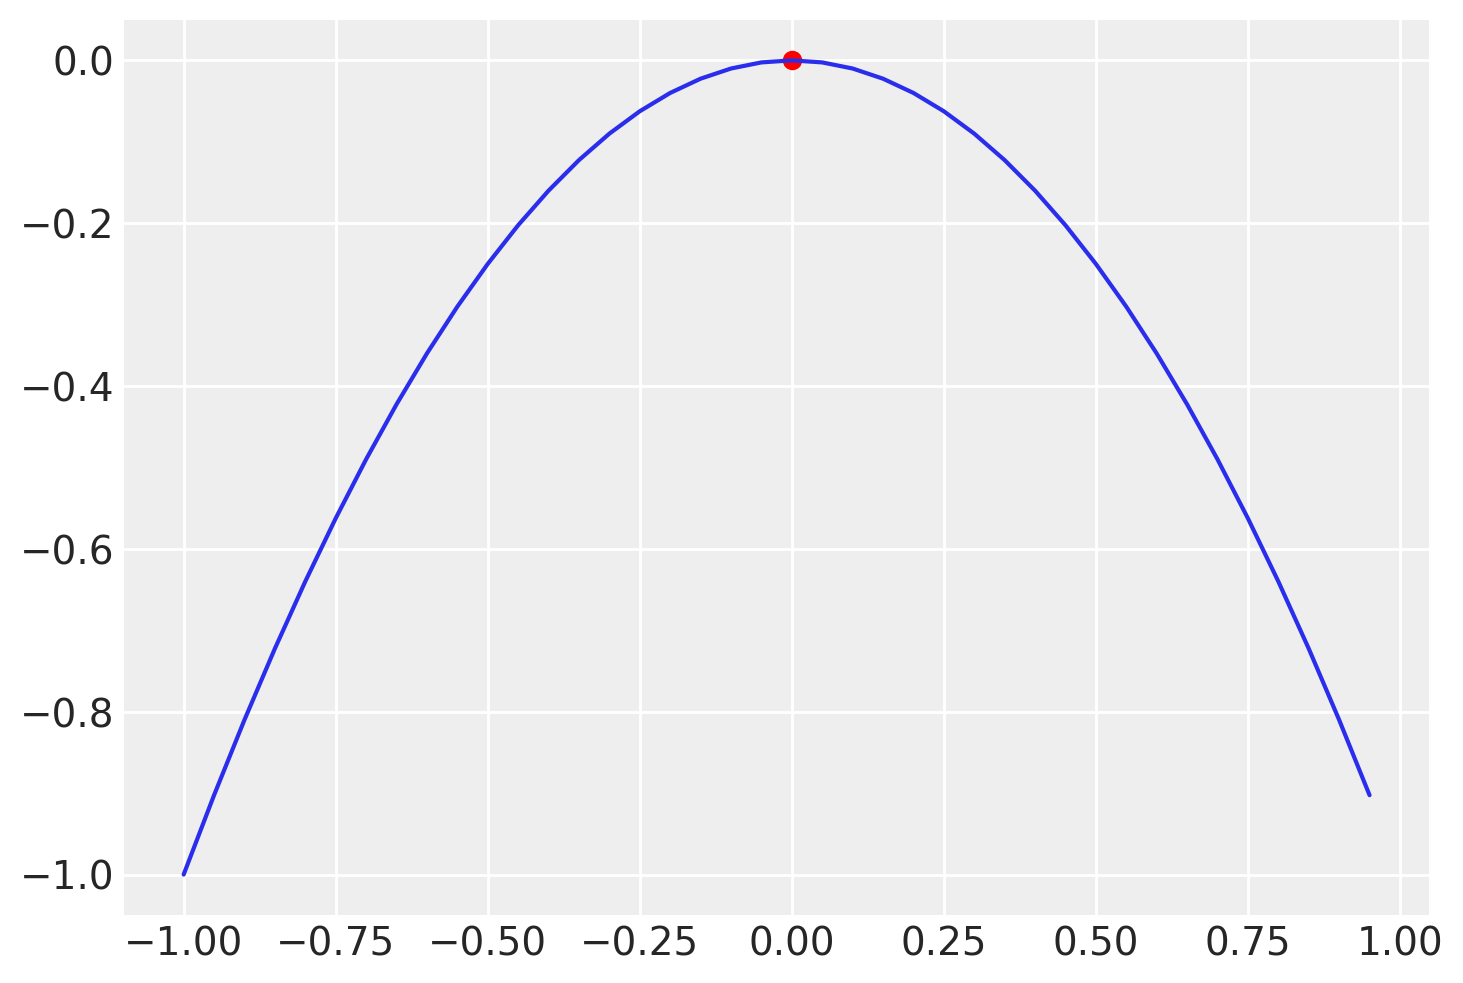

In [131]:
x = np.arange(-1, 1, 0.05)
y = np.arange(-1, 1, 0.05)
y_func = -y**2
map = [0, 0]

def f(x, y):
    return -y**2 + x**2

def grad_f(x, y):
    return np.array([2*x, -2*y])

x_grid, y_grid = np.meshgrid(x, y)
# print(x_grid[:5], x_grid.shape, 2*('\n'), y_grid[:5], y_grid.shape)

grad_f_dot_x_minus_x0 = np.dot(grad_f(x_grid, y_grid), x_grid - map[0])
print(grad_f_dot_x_minus_x0.shape)
###############################################################
### Code Explanation for the `grad_f_dot_x_minus_x0` object ###
# In the context of our x and y grids, grad_f multiplied each number in our x-grid by 2,
# then multiplied each number in our y-grid by -2 AND returned an output with a shape of an array containing two 40 by 40 grids = (2, 40, 40),
# then returned the dot product (np.dot) of our (2, 40, 40) by our x_grid.shape = (40, 40),
# with the final output's shape being (2, 40, 40)
###############################################################


Hessian = np.ones((40, 40)) * 2
hessian_f_dot_x_minus_x0 = np.dot(np.dot(x_grid - map[0], Hessian), (x_grid - map[0]).T)
z_grid = f(x_grid, y_grid) + grad_f_dot_x_minus_x0 + hessian_f_dot_x_minus_x0
print(z_grid.shape, z_grid.reshape(2, -1).T.shape)

plt.plot(x, y_func)
plt.scatter(map[0], map[1], color='red')


# Create the 2 surface plots
surface = go.Surface(x=x_grid, y=y_grid, z=z_grid[0], colorscale='twilight')
surface1 = go.Surface(x=x_grid, y=y_grid, z=z_grid[1], colorscale='twilight')

# Create the scatter plot for the point (0, 0, 0)
scatter = go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', marker=dict(color='violet', size=10))

# Define the layout of the plot
layout = go.Layout(scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'))

# Create the figure
fig = go.Figure(data=[surface, surface1, scatter], layout=layout)

# Show the plot
fig.update_layout(template="plotly_dark")
fig.show()

#### Code 4.28

We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. However, sampling from the model is much simpler if we use the PyMC and the set of "sampler methods" it comes with. The most common sampler methods are members of the **Markov Chain Monte Carlo Method (MCMC)** family (for details, read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

We'll go down the rabbit hole of samplers another day. For now, all you need to know are that some samplers are more suited than others for certain types of variable (and/or problems). Since we're just getting started with samplers, we will rely on PyMC to choose the sampler for us since it does a reasonably good job of providing us with a reasonable starting point for the simulation. By default, PyMC uses the same adaptive procedure as in STAN `'jitter+adapt_diag'`, which starts with an identity mass matrix and then adapts a diagonal based on the variance of the tuning samples.

You can read more details of PyMC [here](https://docs.pymc.io/en/latest/learn/core_notebooks/pymc_overview.html)

ChatGPT-assisted explanation of the code:

Since we've set up a model with certain properties named `m4_1` in Code 4.27, we can also use that model to generate a sample using the Markov Chain Monte Carlo (MCMC) sampling algorithm. In this case, we're generating an object (`trace_4_1`) where MCMC was tuned to 1,000 different samples before generating 1,000 new samples to store in the object.
- Note that "**tuning"** in the context of Bayesian modeling refers to the process of adjusting the hyperparameters of a model in order to optimize its performance. The goal of tuning is to find the best combination of hyperparameters that result in the most accurate predictions or the most accurate estimates of the model's parameters.
- It is similar to training a Machine Learning model, but with some key differences. In ML, we have a training and a test set but in Bayesian modelling, we can use the data for both purpose. Also, in ML, we are looking for the best parameters (weights and biases) that minimize the loss function where in Bayesian modelling, we are looking for the posterior distribution of the parameters which represents the model's uncertainty.

To be more specific, the `pymc.sample()` function used the **No-U-Turn Sampler (NUTS)** as its default sampling algorithm which is a variant of **Hamiltonian Monte Carlo (HMC)** and is designed to automatically tune the step size and number of steps in the Markov chain, which makes it more efficient than other HMC implementations. The `tune` argument in the `pymc.sample()` function controls the number of iterations that the sampler uses to adapt its step size and number of steps.

Some other sampling algorithms that can be used in this function is the **Metropolis-Hastings algorithm**, another general-purpose Markov Chain Monte Carlo (MCMC) algorithm that can be used to sample from a wide range of distributions, and **Slice Sampling**, a univariate MCMC algorithm that works by repeatedly sampling uniformly from a slice of the distribution.


*NOTE: We can get into the details of how Markov Chain Monte Carlo algorithms work in later chapters, especially in Chapter 8. For now, let's focus on understanding quadratic approximation as best we could.*





In [132]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

ChatGPT explanation of a trace plot:

A trace plot, also known as a "trace" or "trace plot," is a visual representation of the values taken by a particular variable throughout the sampling process in a Bayesian analysis. It can be thought of as a time series of the variable, where the time point corresponds to the iteration of the sampling algorithm.

In PyMC, `az.plot_trace()` is a function provided by the arviz library that can be used to create trace plots of the samples generated by the sampling algorithm. It is commonly used to visualize the behavior of the Markov Chain Monte Carlo (MCMC) sampling process. The function takes as input a trace object, which is returned by the `pm.sample()` function and contains the samples generated by the sampling algorithm.

The trace plot shows the value of a variable for each iteration, which can be helpful for understanding how well the sampling algorithm is exploring the parameter space and for identifying potential issues, such as poor mixing or high autocorrelation. It also allows us to see how the posterior is behaving, how it changes over time, or whether it's showing signs of convergence. It's an important diagnostic tool to use when working with Bayesian models.




array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

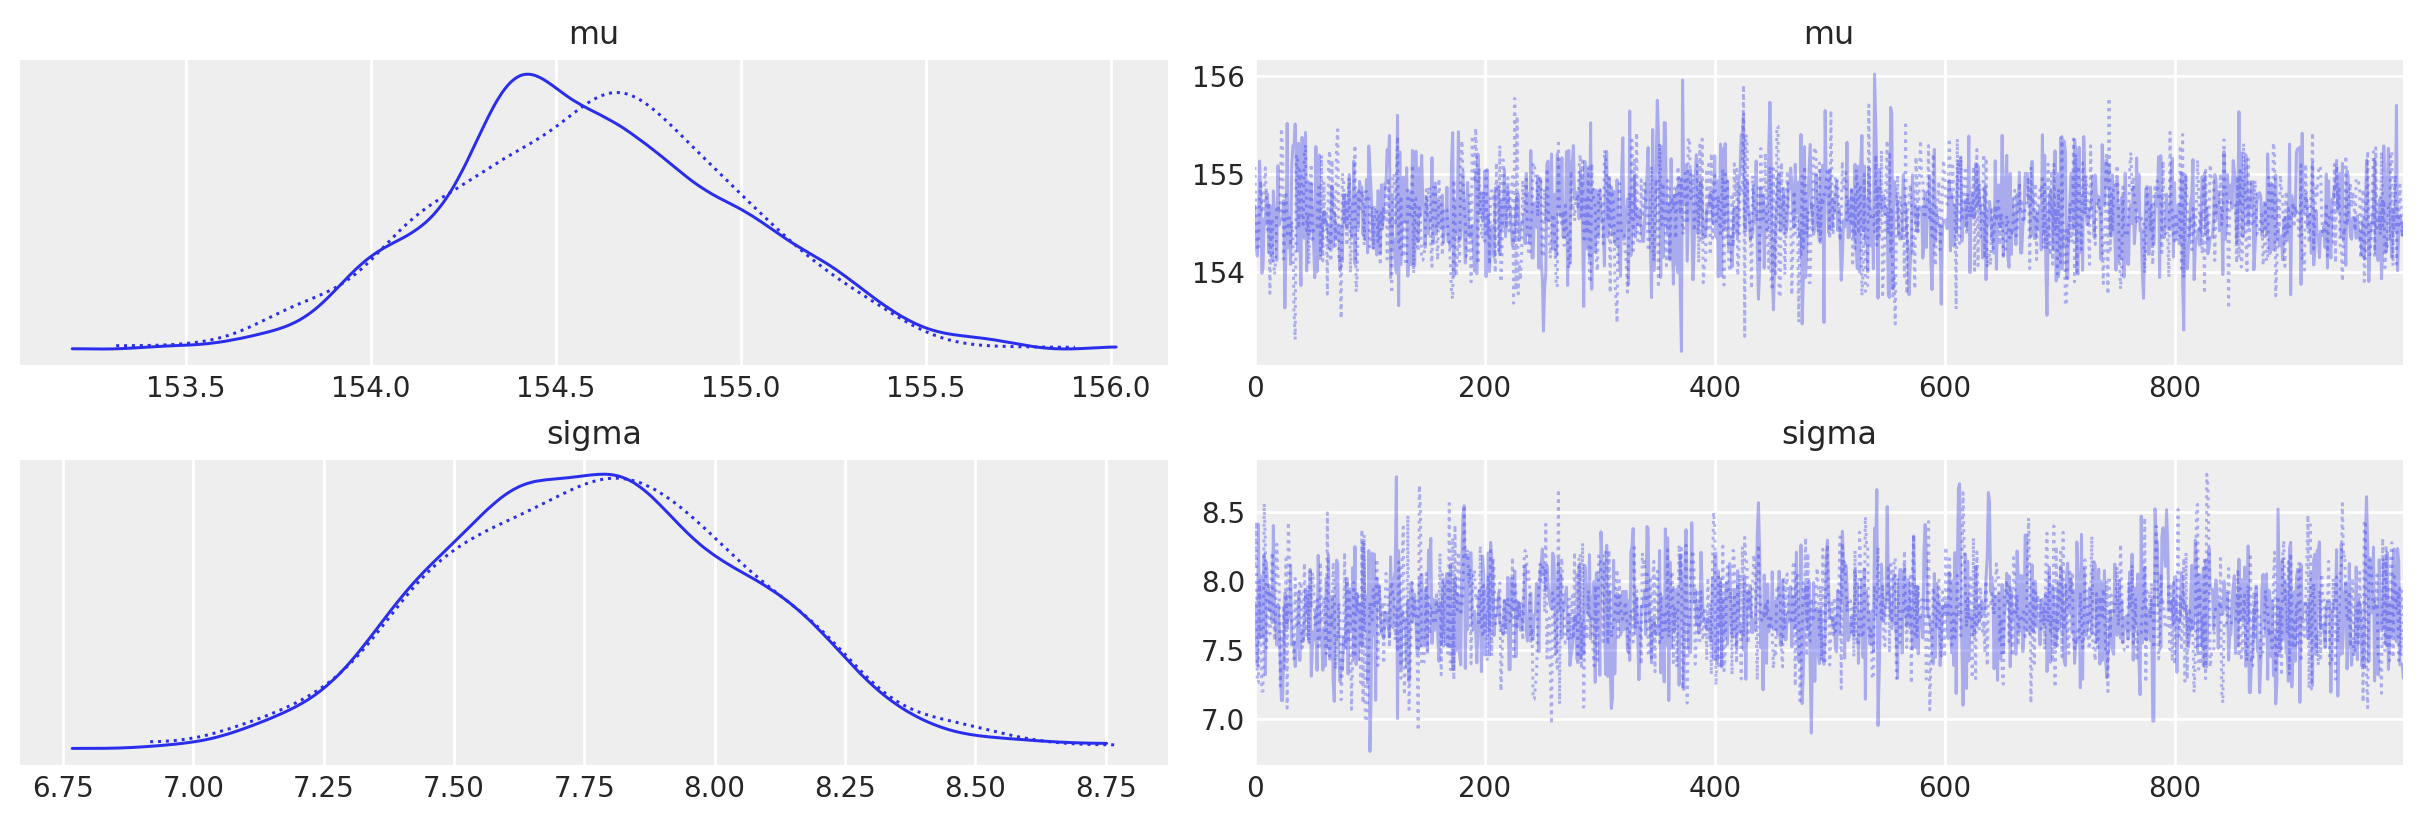

In [133]:
az.plot_trace(trace_4_1)
# this function lets you check the samples values

#### Code 4.29

The summary numbers here provide Gaussian approximations for each parameter's *marginal distribution*. Again, what **marginal distribution** means is that the plausibility of each value in the mean $\mu$ after averaging over the plausibilities of each value in the standard deviations $\sigma$ equates to a Gaussian distribution with a mean of 154.61 and a standard deviation of 0.41. Furthermore, the percentile interval boundaries at the 5.5% and 94.5% quantile are 153.9 and 155.2, respectively, constituting 89% of the entire distribution.

On a side note, the 89% compatibility interval is just the default setting, but if somebody asks you to justify this decision, tell them it's because it's a prime number 😀

In [134]:
az.summary(trace_4_1, round_to=2, kind="stats")

mean    sd  hdi_5.5%  hdi_94.5%
mu     154.59  0.41    153.94     155.23
sigma    7.78  0.31      7.35       8.28

#### **Overthinking: Start values for quadratic approximation.**

**Quadratic approximation** estimates the posterior by climbing it like a hill and will therefore start at some random pair of values sampled from the prior unless told otherwise. One good starting point for these models for finding the maximum a posteriori is to use the mean $\mu$ and the standard deviation $\sigma$ of our dataset's distribution as the arguments for the `testval` parameter.

#### Code 4.30

In [135]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_1 = pm.sample(1000, tune=1000)

<ipython-input-135-ff69e22971cc>:2: FutureWarning:

The `testval` argument is deprecated; use `initval`.

<ipython-input-135-ff69e22971cc>:3: FutureWarning:

The `testval` argument is deprecated; use `initval`.



In [136]:
az.summary(trace_4_1, round_to=2, kind="stats")

mean    sd  hdi_5.5%  hdi_94.5%
mu     154.60  0.41    153.93     155.22
sigma    7.77  0.29      7.30       8.23

#### Code 4.31

Going back to the model we generated in Code 4.27, you'll notice that the priors we generated are pretty weak because both $\mu$ and $\sigma$ were fairly flat and ingesting lots of data. Instead, let's create a new iteration of the model with a more narrow but informative prior for the $\mu$ to illustrate how this difference has such a large effect. The difference with our `m4_2` model is the size of the standard deviation decreasing significantly from 20 to 0.1.



In [137]:
with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sigma=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_2 = pm.sample(1000, tune=1000)
az.summary(trace_4_2, round_to=2, kind="stats")

mean    sd  hdi_5.5%  hdi_94.5%
mu     177.86  0.10    177.70     178.02
sigma   24.62  0.92     23.24      26.20

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

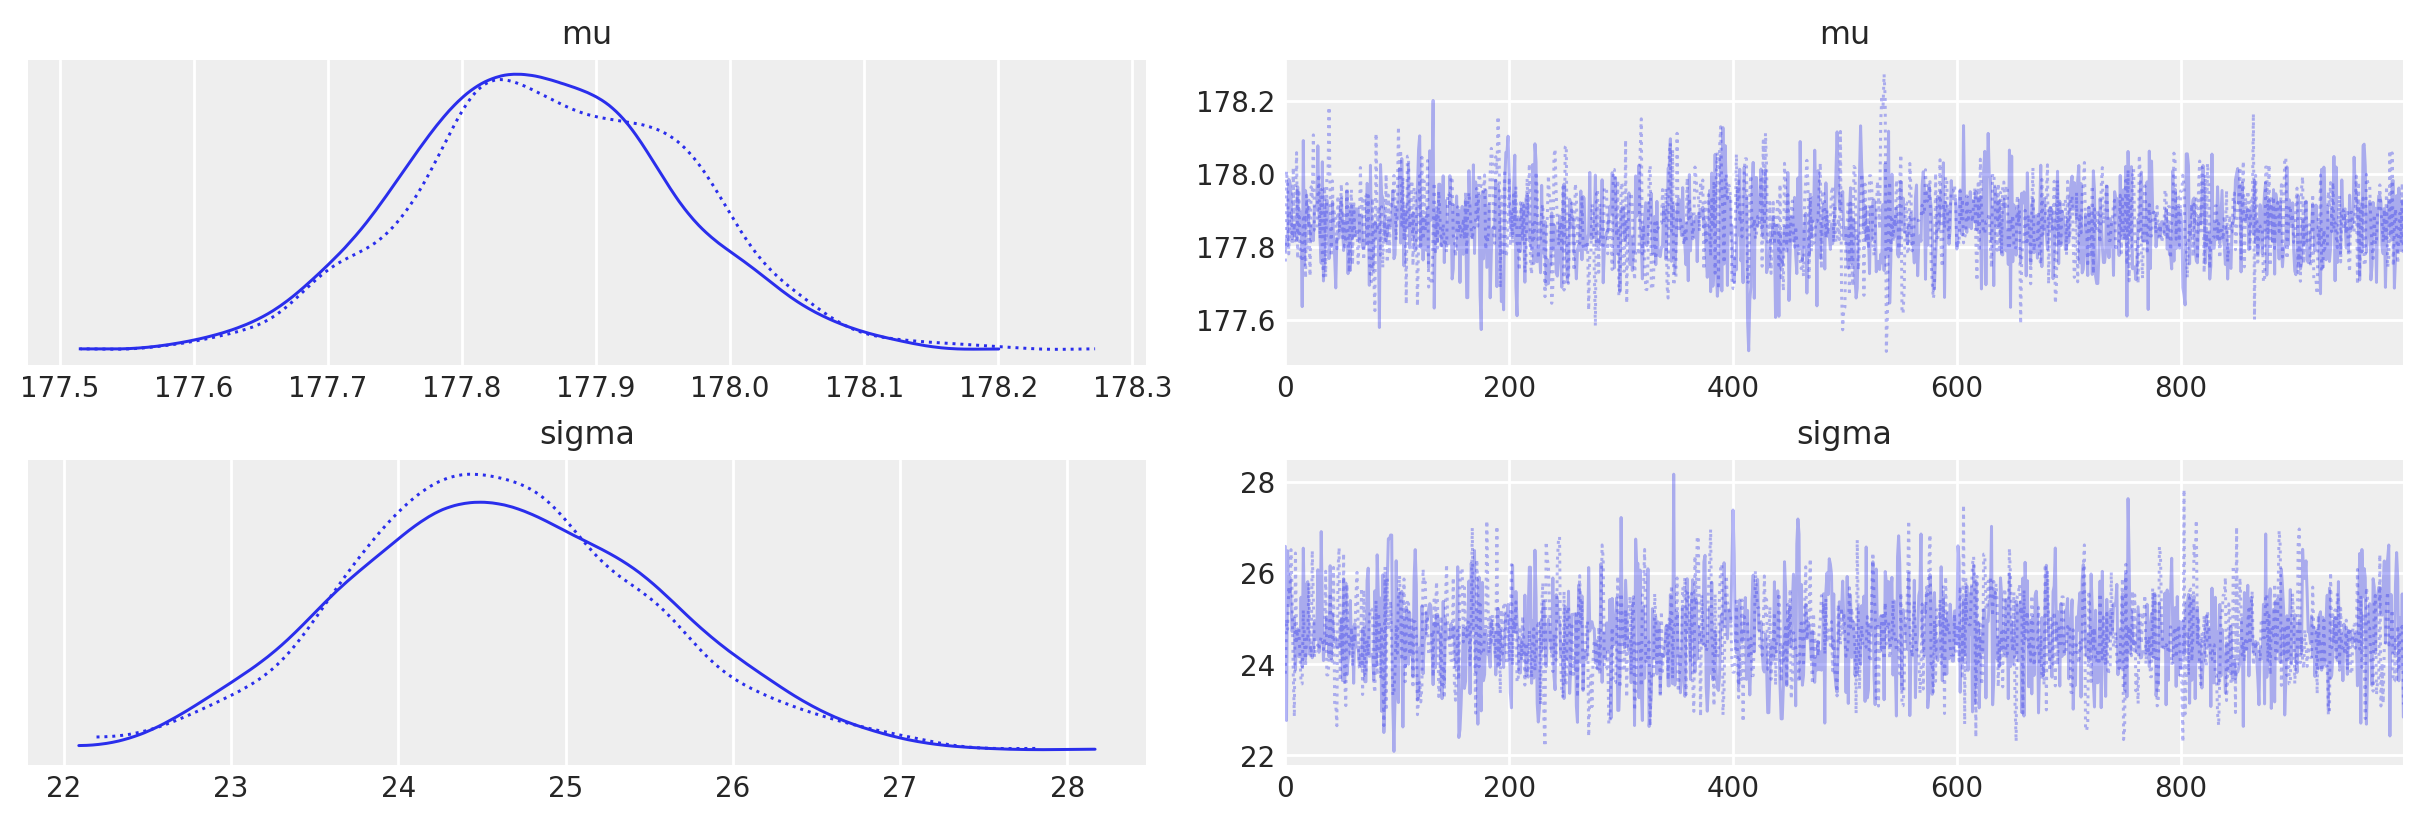

In [138]:
az.plot_trace(trace_4_2)

In this new model implementation with a more narrow prior, notice how the estimate for the mean $\mu$ at 177.86 hardly changes from the prior we initially fed to the model (178). No surprise here. This change lies in stark contrast to our first iteration of this model (`trace_4_1`) with a wider standard deviation for $\mu$, and therefore provided an estimate that departed far more from the original prior (i.e. from a prior $\mu = 178$ to a posterior $\mu = 154.62$). However, the standard deviation $\sigma$ estimate at 7.77 changed quite drastically from the original prior (0.1), even though we made NO CHANGES to the uniform prior distribution of `sigma` itself.

What happened here is that the golem was confident that the mean was near 178; therefore, it had to estimate a new $\sigma$ based on that fact. The end result of this process was a new posterior for that parameter, even though we only changed the arguments for the $\mu$.

In [139]:
# The summary stats of the first implementation of the model:

az.summary(trace_4_1, round_to=2, kind="stats")

mean    sd  hdi_5.5%  hdi_94.5%
mu     154.60  0.41    153.93     155.22
sigma    7.77  0.29      7.30       8.23

### 4.3.6. Sampling from quadratic approximation.

Now that we spent Section 4.3.5 on getting a quadratic approximation of the posterior using PyMC, we can now turn our attention to generating a sample that reflects the posterior distribution. As a reminder, sampling the posterior is how we actually *generate a posterior distribution* and, thus, evaluate it against the data. One way to do so is by treating a quadratic approximation of the posterior distribution as a **multi-dimensional Gaussian distribution** since each parameter (the $\mu$ and the $\sigma$) both contribute one dimension each. Just like how a single mean and standard deviation are enough to describe a single one-dimensional Gaussian distribution, a list of means plus a matrix of variances and covariances are enough to describe a multi-dimensional Gaussian distribution.

To see an example of the **variance-covariance matrix** of samples generated and stored in `trace4_1`, we can use the following chain of methods demonstrated in Code 4.32: `arviz.extract_dataset(obj).to_dataframe().cov()`

#### Code 4.32

For some computations could be nice to have the trace turned into a DataFrame, this can be done using the `trace_to_dataframe` function

In [140]:
trace_df = az.extract_dataset(trace_4_1).to_dataframe()
trace_df.cov()

<ipython-input-140-ed86c72ae319>:1: FutureWarning:

extract_dataset has been deprecated, please use extract



mu     sigma     chain          draw
mu     0.165873 -0.000271 -0.002376      0.336559
sigma -0.000271  0.086862  0.003156     -1.512076
chain -0.002376  0.003156  0.250125      0.000000
draw   0.336559 -1.512076  0.000000  83374.937469

The **variance-covariance matrix** we generated is the multi-dimensional glue of a quadratic approximation because it tells us how much each parameter relates to each other in the posterior distribution. The matrix can be factored into 2 elements:

#### Code 4.33

1. A vector (i.e. list) of variances for the parameters which can be converted into standard deviation if we take the square roots of these numbers. And...

In [141]:
np.diag(trace_df.cov())

array([1.65873002e-01, 8.68620236e-02, 2.50125063e-01, 8.33749375e+04])

2. A correlation matrix that tells us how changes in any parameter lead to correlated changes in the others.

<Axes: >

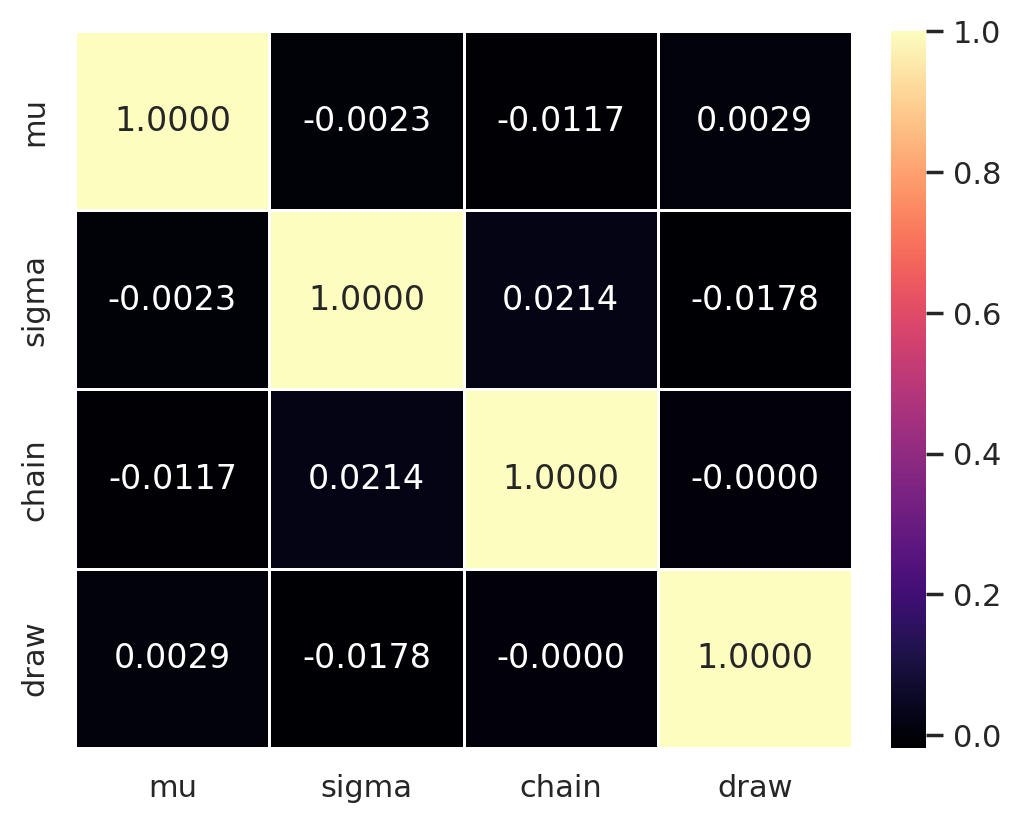

In [142]:
import seaborn as sns

mask = np.triu(np.ones_like(trace_df.corr(), dtype=bool))

sns.set(rc = {'figure.figsize':(5,4)})
sns.heatmap(trace_df.corr(), annot=True, fmt=".4f", linewidth=.5, cmap='magma')

The results for these correlation heatmap tells us that learning something about the $\mu$, for example, tells us nothing about the $\sigma$ since there's almost no correlation between them. In fact, there's pretty much zero correlation amongst all the parameters in our heatmap which is typical in simple Gaussian models, but is actually quite rare for models in the wild.

#### Code 4.34

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like:

In [143]:
trace_df.head()

mu     sigma  chain  draw
chain draw                                   
0     0     154.134379  7.785225      0     0
      1     154.700406  7.718347      0     1
      2     154.320446  7.708925      0     2
      3     154.572753  8.222397      0     3
      4     154.480018  7.261615      0     4

Or directly from the trace (we are getting the first ten samples of _sigma_)

In [144]:
trace_4_1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [145]:
trace_4_1.posterior["sigma"][0][:10]

<xarray.DataArray 'sigma' (draw: 10)>
array([7.78522506, 7.71834732, 7.70892525, 8.22239698, 7.26161521,
       8.29251422, 7.7861144 , 7.57268893, 7.87490022, 7.52928093])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9

We can also convert the following R code in Code 4.34 on p.90 back into Python by converting the `mu` and the `sigma` values from our `trace4_1` object into a DataFrame and then calling the first 5 values:

```
library(rethinking)
post <- extract.samples(m4.1 , n=1e4)
head(post)
```

In [146]:
post = pd.DataFrame({"mu": trace_4_1["posterior"]["mu"][0].to_dict()["data"],
                     "sigma": trace_4_1["posterior"]["sigma"][0].to_dict()["data"]})

post.head()

mu     sigma
0  154.134379  7.785225
1  154.700406  7.718347
2  154.320446  7.708925
3  154.572753  8.222397
4  154.480018  7.261615

#### Code 4.35

In our case, this is the same we did in the code 4.27

We can also gain a high-level understanding of the dataframe we generated by using the `describe()` function on the posterior distribution we stored in the `post` object, and compare it with the summary statistics we can generate from the model itself `trace_4_1`.

In [147]:
# az.summary(trace_4_1, round_to=2, kind="stats")
print(post.describe(), '\n')
print(az.summary(trace_4_1, round_to=2, kind="stats").T, '\n')

                mu        sigma
count  1000.000000  1000.000000
mean    154.603325     7.760976
std       0.399557     0.296656
min     153.397484     6.868774
25%     154.347861     7.550176
50%     154.602247     7.748291
75%     154.861286     7.953964
max     156.110568     8.669421 

               mu  sigma
mean       154.60   7.77
sd           0.41   0.29
hdi_5.5%   153.93   7.30
hdi_94.5%  155.22   8.23 



#### Overthinking: Under the hood with multivariate sampling

We can also do the same thing by generating a simulation of values you might expect to get from `posterior` samples of a `trace_4_1` object by running the `scipy.stats.multivariate_normal.rvs()` function on the `trace_df` DataFrame. The `multivariate_normal.rvs()` function simulates random vectors of multivariate Gaussian values, which is essentially what our `m4_1` object is by containing distributions of the mean and standard deviation. The equation for the probability function of a [Multivariate Normal Distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) \([Degenerate Case](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Degenerate_case)\) is the following:

$$ f(x) = \frac{1}{\sqrt{(2 \pi)^k \det \Sigma}} \exp( - \frac{1}{2}(x - \mu)^{T \Sigma^{-1}}(x - \mu) ) $$

You don't usually need to use this function with PyMC. But, of course, you can use it for other non-PyMC use cases that require you to simulate multivariate Gaussian outcomes.

#### Code 4.36

In [148]:
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10000)

array([[ 1.54469693e+02,  7.88959321e+00,  1.18454558e+00,
         3.99806096e+02],
       [ 1.54894441e+02,  7.88878790e+00,  5.54285996e-01,
         9.59515474e+02],
       [ 1.54077430e+02,  8.11703456e+00, -7.30680643e-01,
         4.37896631e+02],
       ...,
       [ 1.54717117e+02,  7.68642783e+00,  2.53083764e-01,
         2.16432697e+02],
       [ 1.54627205e+02,  7.60392944e+00,  4.66698301e-01,
         5.25755001e+02],
       [ 1.54787904e+02,  7.24543585e+00,  2.98611306e-01,
         4.92897173e+02]])

And that's a wrap for Part 1 of Chapter 4! In Part 2, we'll begin building an intuition for Bayesian flavours of Regression models. Click here to learn more.